# Forecast

In [2]:
# from sklearn.inspection import permutation_importance
# from sklearn.feature_selection import SelectFromModel

# # import seaborn as sns
# # import sklearn
# import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

from pyspark.sql import SparkSession
from glob import glob

from pyspark.sql.types import FloatType
from pyspark.sql.functions import (
    to_date, regexp_replace, udf, col, length, when, year, lit
)

import matplotlib.pyplot as plt
import pyaiutils as pai
import tensorflow as tf
import pandas as pd
import numpy as np
import pathlib
import pickle
import shap

spark = SparkSession.builder \
    .master("local") \
    .appName("master-covid") \
    .getOrCreate()
spark.sparkContext.setLogLevel("FATAL")

#### Variáveis

In [3]:
PATH_DATA = 'datas'
PATH_RESULT = 'results'

#### Funções

Função para exibir o o histórico de treinamento

- history: history de treinamento

In [4]:
def show_history(path: str, type: str = 'acc'):
    """_summary_

    Parameters
    ----------
    path : str
        _description_
    type : str, optional
        acc or categorical_accuracy, by default 'acc'
    """
    with open(path, 'rb') as f:
        history = pickle.load(f)

    print(history.keys())

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 7))

    ax[0].set_ylabel('Categorical Crossentropy')
    ax[0].plot(range(len(history['loss'])), history['loss'], label='Loss do treino', color='k', linewidth=1.2)
    ax[0].plot(range(len(history['loss'])), history['val_loss'], label='Loss da validação', color='k', linestyle='--', linewidth=1.2)
    ax[0].legend()

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Acurácia')
    ax[1].plot(range(len(history['loss'])), history[type], label='Acurácia do treino', color='k', linewidth=1.2)
    ax[1].plot(range(len(history['loss'])), history[f'val_{type}'], label='Acurácia da validação', color='k', linestyle='--', linewidth=1.2)
    ax[1].legend()

    plt.show()

Metrics

In [5]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [7]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Função para avaliação do modelo
- model: modelo
- x_test: dataframe de entrada
- y_test: dataframe alvo
- class_names: classes
- path: caminho para armazenar os resultados

In [8]:
def evaluate(
    model: tf.keras.Sequential,
    x_test: np.ndarray,
    y_test: np.ndarray,
    class_names: list[str],
    path: str
) -> None:
    y_pred = model.predict(x_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    pai.plot_graphics(y_true, y_pred, class_names=class_names, save_path=path)
    display(pai.get_metrics(y_true, y_pred, class_names=class_names, save_path=path))

## Classificação

Algoritmos de classificação

![title](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

Métricas de avaliação

Matriz de Confusão | Recall vs Precision | Equação de 4 diferentes métricas
- | - | -
![](https://miro.medium.com/max/1400/1*N6I3pi0prhiJ_Y85HAx4wA.png) | ![](https://miro.medium.com/max/700/0*uhuG2rhX6XzNC43X.png) | ![](https://miro.medium.com/max/1400/1*UVP_xb4F6J-M-xH3haz5Jw.png)

### COVID/OUTRA-SRAG

Carregando dataframe:

|sintomas|comorbidades|sexo|SRAG|
|--|--|--|--|
|1. Sim|1. Sim|1: Masculino|0. Outra SRAG|
|2. Não|2. Não|2: Feminino|1. Covid|
|9. Ignorado|9. Ignorado|9: Ignorado||
|0. NULL|0. NULL|||


In [9]:
df = spark.read.parquet(f'{PATH_DATA}/prepare/c0/3-enrich.parquet')
df.show()

+-------+-----+-----+--------+--------+--------+----------+----------+---------+---------+------+-----+
|CS_SEXO|FEBRE|TOSSE|DISPNEIA|GARGANTA|DIARREIA|CARDIOPATI|CLASSI_FIN|DESC_RESP|SATURACAO|VOMITO|IDADE|
+-------+-----+-----+--------+--------+--------+----------+----------+---------+---------+------+-----+
|      1|    1|    1|       1|       2|       2|         0|         0|        1|        1|     2|    0|
|      1|    1|    1|       1|       2|       1|         0|         0|        1|        1|     1|    0|
|      2|    1|    1|       1|       1|       2|         0|         0|        2|        2|     2|   29|
|      1|    1|    1|       1|       1|       2|         0|         0|        2|        2|     2|   32|
|      2|    1|    1|       2|       1|       2|         0|         1|        1|        1|     2|   32|
|      1|    1|    1|       1|       0|       0|         0|         0|        1|        0|     0|    0|
|      1|    1|    1|       2|       2|       2|         0|     

In [10]:
df.groupBy('CLASSI_FIN').count().show()

+----------+-------+
|CLASSI_FIN|  count|
+----------+-------+
|         1|1807429|
|         0| 524824|
+----------+-------+



Listando as colunas existentes

In [11]:
df.columns

['CS_SEXO',
 'FEBRE',
 'TOSSE',
 'DISPNEIA',
 'GARGANTA',
 'DIARREIA',
 'CARDIOPATI',
 'CLASSI_FIN',
 'DESC_RESP',
 'SATURACAO',
 'VOMITO',
 'IDADE']

Delimitando as colunas de interesse

In [18]:
symptoms = [
    'FEBRE',
    'TOSSE',
    'DISPNEIA',
    'GARGANTA',
    'DIARREIA',
    'DESC_RESP',
    'SATURACAO',
    'VOMITO',
]
comorbidities = [
    'CARDIOPATI',
]

Colunas para estudo

In [19]:
x_cols = [
    *symptoms,
    *comorbidities,
    'IDADE',
    'CS_SEXO',
]
y_cols = ['CLASSI_FIN']

Split dataset
- train 60
- test 20
- val 20

In [14]:
x_train, x_val, y_train, y_val = train_test_split(
    df.select(x_cols).collect(),
    df.select(y_cols).collect(),
    test_size=0.2,
    random_state=1
)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    x_train,
    y_train,
    test_size=0.25,
    random_state=1
)

Normalizando os dados de entrada

In [16]:
x_scaler = MinMaxScaler((0,1))

x_train = x_scaler.fit_transform(x_train)
x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)

In [17]:
scalers = f'{PATH_RESULT}/scalers/c0'
pathlib.Path(scalers).mkdir(parents=True, exist_ok=True)

In [18]:
pickle.dump(x_scaler, open(f'{scalers}/xscaler.pkl', 'wb'))

In [19]:
prepared_data = f'{PATH_DATA}/prepare/c0'
pathlib.Path(prepared_data).mkdir(parents=True, exist_ok=True)

In [20]:
pd.DataFrame(x_train, columns=x_cols).to_csv(f'{prepared_data}/xtrain.csv.gz', compression='gzip', index=False)
pd.DataFrame(y_train, columns=y_cols).to_csv(f'{prepared_data}/ytrain.csv.gz', compression='gzip', index=False)
pd.DataFrame(x_val, columns=x_cols).to_csv(f'{prepared_data}/xval.csv.gz', compression='gzip', index=False)
pd.DataFrame(y_val, columns=y_cols).to_csv(f'{prepared_data}/yval.csv.gz', compression='gzip', index=False)
pd.DataFrame(x_test, columns=x_cols).to_csv(f'{prepared_data}/xtest.csv.gz', compression='gzip', index=False)
pd.DataFrame(y_test, columns=y_cols).to_csv(f'{prepared_data}/ytest.csv.gz', compression='gzip', index=False)

Conversão da saída para categorical (One Hot Encoding)

In [21]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [22]:
classes_target = ['Outra-SRAG', 'Covid-19']
pd.DataFrame(y_train, columns=classes_target).to_csv(f'{prepared_data}/ytrain_ohe.csv', compression='gzip', index=False)
pd.DataFrame(y_val, columns=classes_target).to_csv(f'{prepared_data}/yval_ohe.csv', compression='gzip', index=False)
pd.DataFrame(y_test, columns=classes_target).to_csv(f'{prepared_data}/ytest_ohe.csv', compression='gzip', index=False)

#### RNA (MLP)

In [11]:
model_mlp = f'{PATH_RESULT}/models/c0/mlp'
pathlib.Path(model_mlp).mkdir(parents=True, exist_ok=True)

otimizador

In [24]:
model_o = tf.keras.models.load_model(
    f'{model_mlp}/init_weights_nsgaii_best_model.h5',
    custom_objects = {
        'precision_m': precision_m,
        'recall_m': recall_m,
        'f1_m': f1_m
    }
)
model_o.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 dense_2 (Dense)             (None, 51)                969       
                                                                 
 dense_3 (Dense)             (None, 88)                4576      
                                                                 
 dense_4 (Dense)             (None, 76)                6764      
                                                                 
 dense_5 (Dense)             (None, 51)                3927      
                                                                 
 dense_1 (Dense)             (None, 2)                 104       
                                                                 
Total params: 16,340
Trainable params: 16,340
Non-trainable

2022-07-10 19:45:11.246132: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-07-10 19:45:11.246238: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: predator
2022-07-10 19:45:11.246247: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: predator
2022-07-10 19:45:11.246544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-07-10 19:45:11.246608: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-07-10 19:45:11.246621: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.48.7 does not match DSO version 510.73.5 -- cannot find working devices in this configuration
2022-07-10 19:45:11.247028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow

dict_keys(['val_loss', 'val_categorical_accuracy', 'val_precision_m', 'val_recall_m', 'val_f1_m', 'loss', 'categorical_accuracy', 'precision_m', 'recall_m', 'f1_m'])


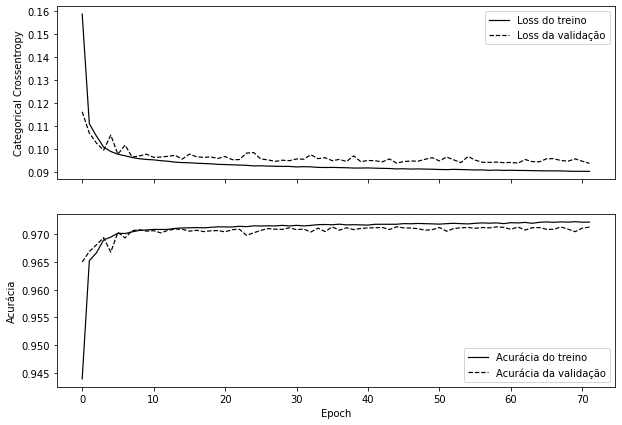

In [25]:
show_history(f'{model_mlp}/history_nsgaii_best_model.pk', 'categorical_accuracy')

---

In [12]:
model = tf.keras.models.load_model(
    f'{model_mlp}/best_model.h5',
    custom_objects = {
        'precision_m': precision_m,
        'recall_m': recall_m,
        'f1_m': f1_m
    }
)
model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 51)                612       
                                                                 
 dense_1 (Dense)             (None, 88)                4576      
                                                                 
 dropout (Dropout)           (None, 88)                0         
                                                                 
 dense_2 (Dense)             (None, 76)                6764      
                                                                 
 dense_3 (Dense)             (None, 51)                3927      
                                                                 
 dense_4 (Dense)             (None, 2)                 104       
                                                                 
Total params: 15,983
Trainable params: 15,983
Non-trainable par

2022-07-10 21:51:57.919353: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-07-10 21:51:57.919415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: predator
2022-07-10 21:51:57.919420: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: predator
2022-07-10 21:51:57.919639: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-07-10 21:51:57.919680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-07-10 21:51:57.919689: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.48.7 does not match DSO version 510.73.5 -- cannot find working devices in this configuration
2022-07-10 21:51:57.920040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow

In [13]:
def mlp_model(input_shape: tuple) -> tf.keras.Model:
    tf.keras.backend.clear_session()
#     tf.random.set_seed(0)

    opt = tf.keras.optimizers.SGD(learning_rate=0.41001897516490954)
    auc = tf.keras.metrics.AUC()

    model = tf.keras.models.Sequential(name='mlp')
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(units=51, activation='elu'))
    model.add(tf.keras.layers.Dense(units=88, activation='softsign'))
    model.add(tf.keras.layers.Dropout(rate=0.4))
    model.add(tf.keras.layers.Dense(units=76, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=51, activation='elu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['acc', precision_m, recall_m, f1_m, auc]
    )
    return model

In [14]:
monitor = 'val_loss'
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{model_mlp}/best_model.h5', monitor=monitor, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir=f'{model_mlp}/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=7, min_delta=1e-4, mode='min'),
]

In [33]:
model = mlp_model((x_train.shape[1],))
# train the neural network
H = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,#72,
    batch_size=179,
    callbacks=callbacks
)

# Uncomment if you don't use callbacks
# model.save(f'{path_mlpcovid}/best_model.h5')

with open(f'{model_mlp}/history_best_model.pkl', 'wb') as f:
    pickle.dump(H.history, f)

Epoch 1/200
7818/7818 [==============================] - 16s 2ms/step - loss: 0.6194 - acc: 0.7781 - precision_m: 0.7781 - recall_m: 0.7781 - f1_m: 0.7781 - auc: 0.7824 - val_loss: 0.6128 - val_acc: 0.7741 - val_precision_m: 0.7741 - val_recall_m: 0.7741 - val_f1_m: 0.7741 - val_auc: 0.7741 - lr: 0.4100
Epoch 2/200
7818/7818 [==============================] - 15s 2ms/step - loss: 0.6132 - acc: 0.7748 - precision_m: 0.7748 - recall_m: 0.7748 - f1_m: 0.7748 - auc: 0.7752 - val_loss: 0.6152 - val_acc: 0.7741 - val_precision_m: 0.7741 - val_recall_m: 0.7741 - val_f1_m: 0.7741 - val_auc: 0.7741 - lr: 0.4100
Epoch 3/200
7818/7818 [==============================] - 15s 2ms/step - loss: 0.6134 - acc: 0.7748 - precision_m: 0.7748 - recall_m: 0.7748 - f1_m: 0.7748 - auc: 0.7751 - val_loss: 0.6163 - val_acc: 0.7741 - val_precision_m: 0.7741 - val_recall_m: 0.7741 - val_f1_m: 0.7741 - val_auc: 0.7539 - lr: 0.4100
Epoch 4/200
7818/7818 [==============================] - 15s 2ms/step - loss: 0.3280 

dict_keys(['loss', 'acc', 'precision_m', 'recall_m', 'f1_m', 'auc', 'val_loss', 'val_acc', 'val_precision_m', 'val_recall_m', 'val_f1_m', 'val_auc', 'lr'])


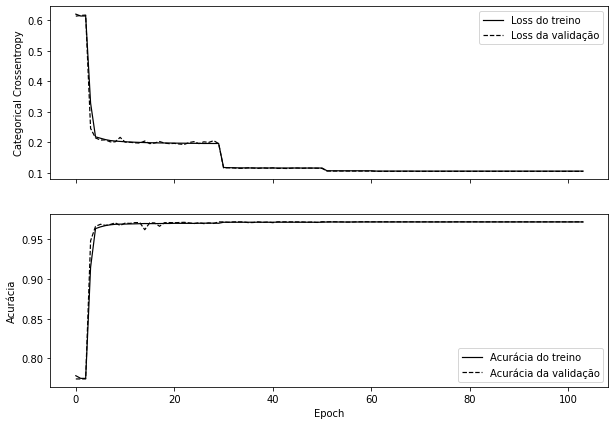

In [34]:
show_history(f'{model_mlp}/history_best_model.pkl')

14577/14577 [==============================] - 10s 667us/step


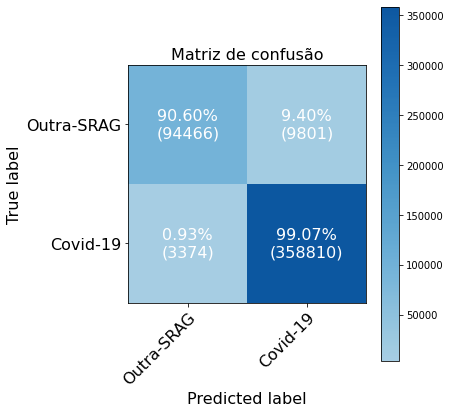

None

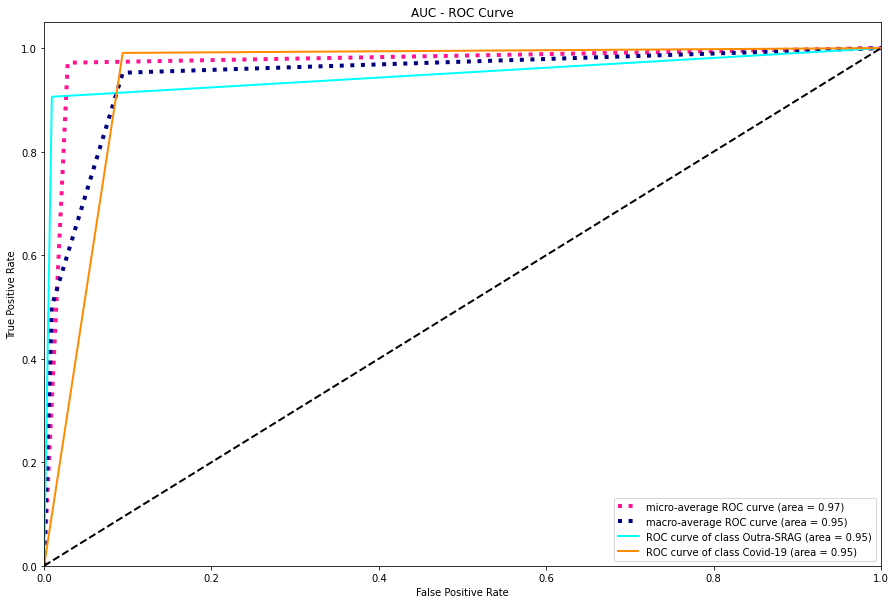

None

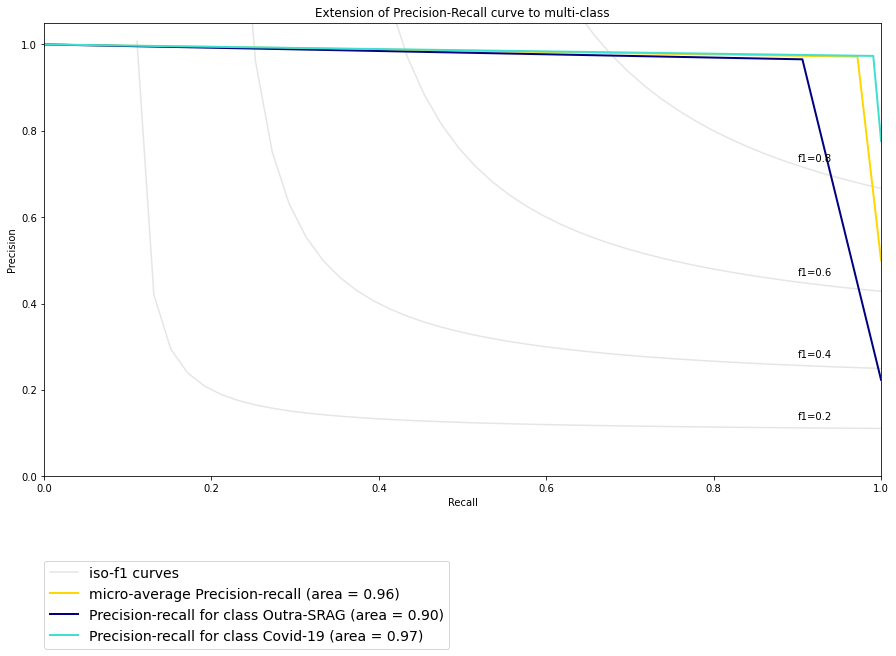

None

Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.90       0.97    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.94       0.97    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97

In [35]:
evaluate(
    model=model,
    x_test=x_test,
    y_test=y_test,
    class_names=['Outra-SRAG', 'Covid-19'],
    path=model_mlp
)

In [81]:
# background = x_train[np.random.choice(x_train.shape[0], size=100, replace=False)]
# # type(np.array(x_train[np.random.choice(x_train.shape[0], size=10000, replace=False)])
# # explainer = shap.GradientExplainer(model, pd.DataFrame(x_train)[:1000])
# explainer = shap.GradientExplainer(model, background)
# samples = x_test[np.random.choice(x_test.shape[0], 10, replace=False)]
# shap_values = explainer.shap_values(samples)
# # shap.summary_plot(shap_values, samples, feature_names=x_cols, class_names=['Outra-SRAG', 'Covid-19'], show=False)
# # plt.savefig(f'{model_mlp}/shap_summary.png')
# # plt.show()

In [51]:
# class_names = ['Outra-SRAG', 'Covid-19']
# for feat in x_cols:
#     for clss in range(len(class_names)):
#         shap.dependence_plot(
#             feat,
#             shap_values[clss],
#             samples,
#             interaction_index='idade',
#             alpha=0.5,
#             feature_names=x_cols,
#             show=False
#         )
#         plt.savefig(f'{model_mlp}/dependence/{class_names[clss]}_{feat}.png')

#### RNA (MLP) K-FOLD

In [15]:
mlp_kfold = f'{model_mlp}/kfold'
pathlib.Path(mlp_kfold).mkdir(parents=True, exist_ok=True)

Epoch 1/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2316 - acc: 0.9607 - precision_m: 0.9607 - recall_m: 0.9607 - f1_m: 0.9607 - auc: 0.9830
Epoch 2/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2078 - acc: 0.9674 - precision_m: 0.9674 - recall_m: 0.9674 - f1_m: 0.9674 - auc: 0.9850
Epoch 3/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2040 - acc: 0.9689 - precision_m: 0.9689 - recall_m: 0.9689 - f1_m: 0.9689 - auc: 0.9855
Epoch 4/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2023 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9694 - f1_m: 0.9694 - auc: 0.9857
Epoch 5/104
12378/12378 [==============================] - 20s 2ms/step - loss: 0.2012 - acc: 0.9696 - precision_m: 0.9696 - recall_m: 0.9696 - f1_m: 0.9696 - auc: 0.9859
Epoch 6/104
12378/12378 [==============================] - 20s 2ms/step - loss: 0.2005 - acc: 0.9697 - precision_m: 0.9697 - recall_m: 0.9697 - f

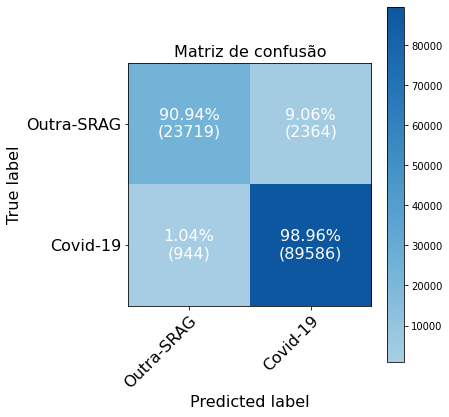

None

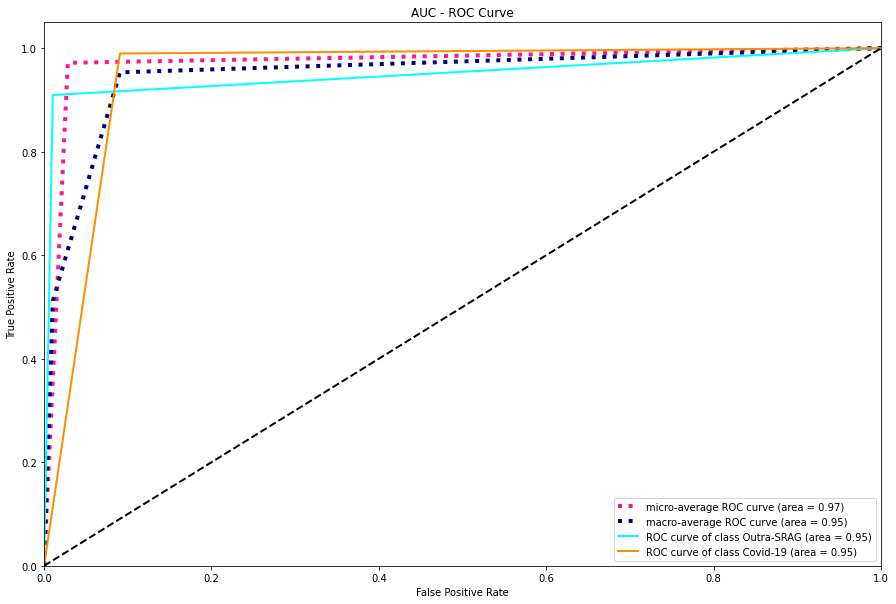

None

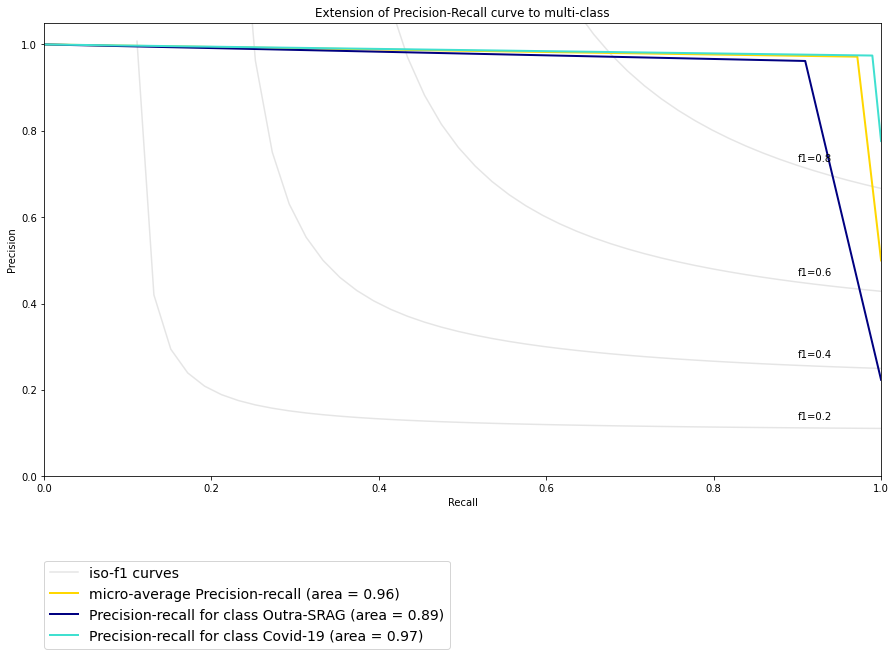

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.96    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.93       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2341 - acc: 0.9598 - precision_m: 0.9598 - recall_m: 0.9598 - f1_m: 0.9598 - auc: 0.9825
Epoch 2/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2084 - acc: 0.9672 - precision_m: 0.9672 - recall_m: 0.9672 - f1_m: 0.9672 - auc: 0.9849
Epoch 3/104
12378/12378 [==============================] - 20s 2ms/step - loss: 0.2043 - acc: 0.9687 - precision_m: 0.9687 - recall_m: 0.9687 - f1_m: 0.9687 - auc: 0.9855
Epoch 4/104
12378/12378 [==============================] - 22s 2ms/step - loss: 0.2024 - acc: 0.9693 - precision_m: 0.9693 - recall_m: 0.9

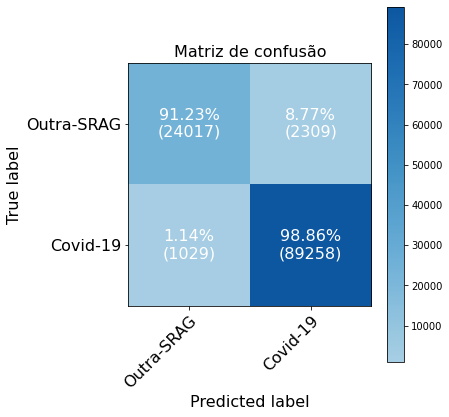

None

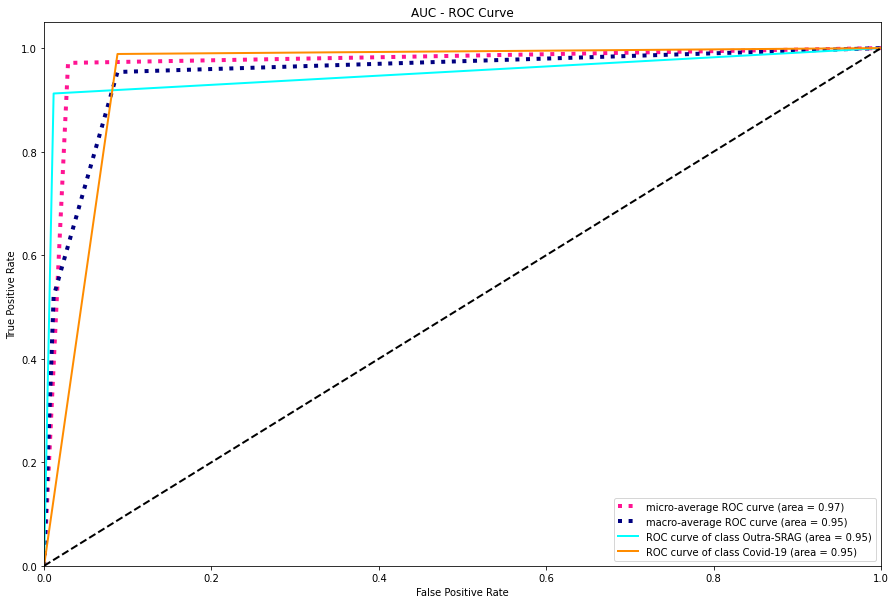

None

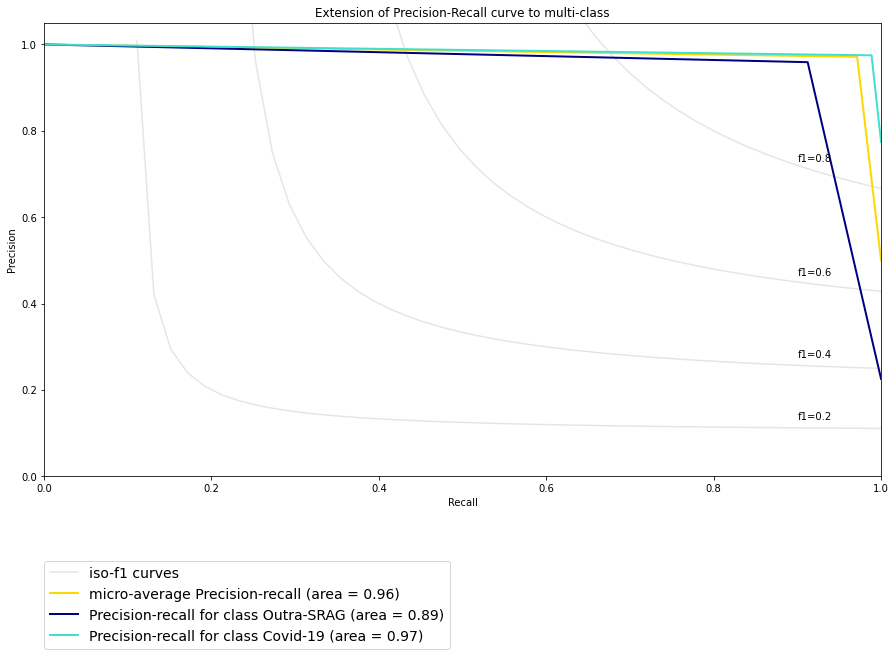

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.94     0.95     0.89       0.96    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.93       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2374 - acc: 0.9592 - precision_m: 0.9592 - recall_m: 0.9592 - f1_m: 0.9592 - auc: 0.9819
Epoch 2/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2085 - acc: 0.9671 - precision_m: 0.9671 - recall_m: 0.9671 - f1_m: 0.9671 - auc: 0.9852
Epoch 3/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2046 - acc: 0.9687 - precision_m: 0.9687 - recall_m: 0.9687 - f1_m: 0.9687 - auc: 0.9857
Epoch 4/104
12378/12378 [==============================] - 20s 2ms/step - loss: 0.2024 - acc: 0.9691 - precision_m: 0.9691 - recall_m: 0.9

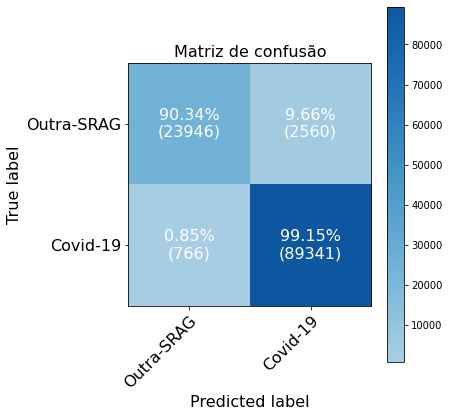

None

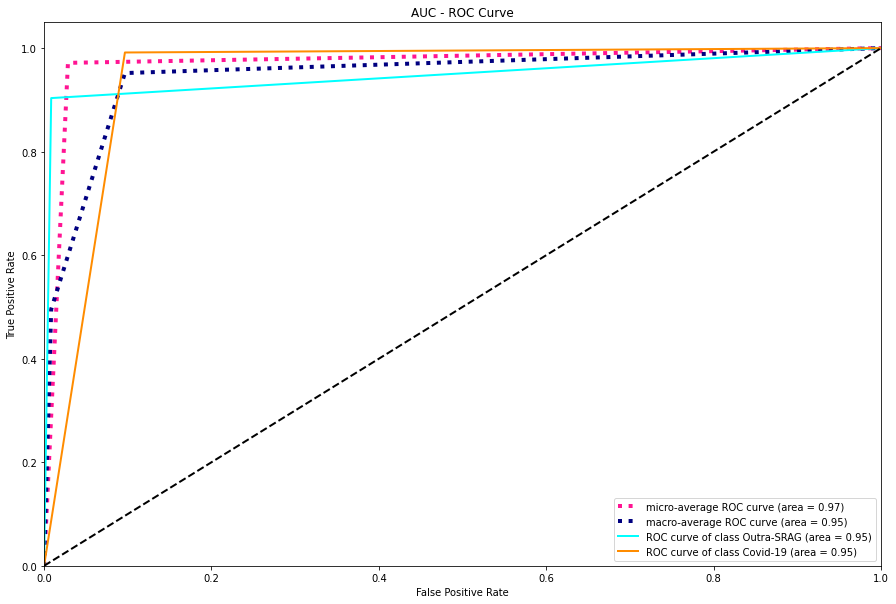

None

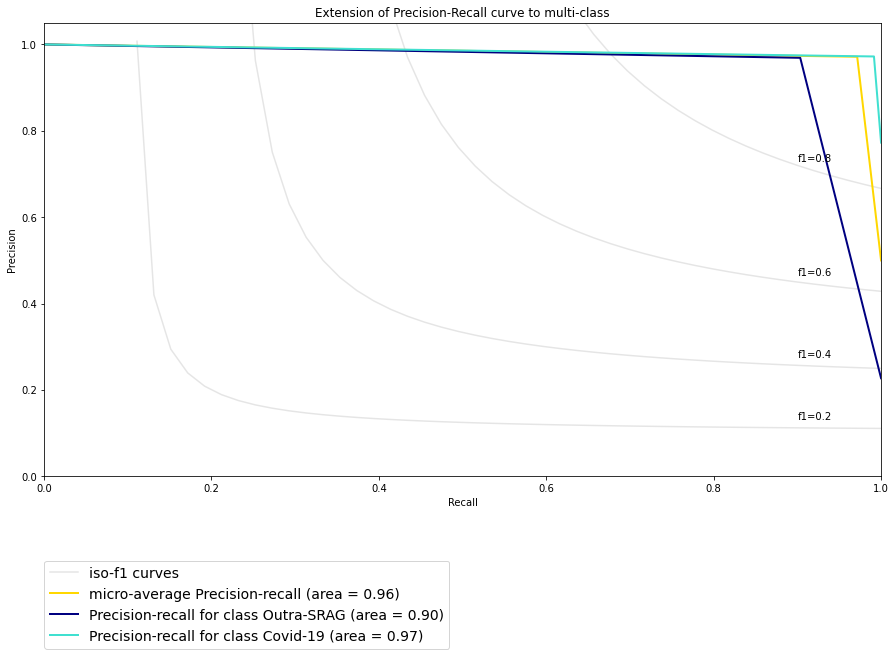

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.94     0.95     0.90       0.97    0.90         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.90   
2       Média  0.96     0.95     0.94       0.97    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2355 - acc: 0.9597 - precision_m: 0.9597 - recall_m: 0.9597 - f1_m: 0.9597 - auc: 0.9824
Epoch 2/104
12378/12378 [==============================] - 19s 2ms/step - loss: 0.2087 - acc: 0.9669 - precision_m: 0.9669 - recall_m: 0.9669 - f1_m: 0.9669 - auc: 0.9849
Epoch 3/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2048 - acc: 0.9685 - precision_m: 0.9685 - recall_m: 0.9685 - f1_m: 0.9685 - auc: 0.9855
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2032 - acc: 0.9690 - precision_m: 0.9690 - recall_m: 0.9

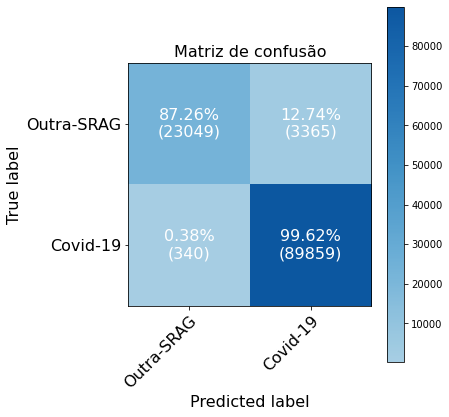

None

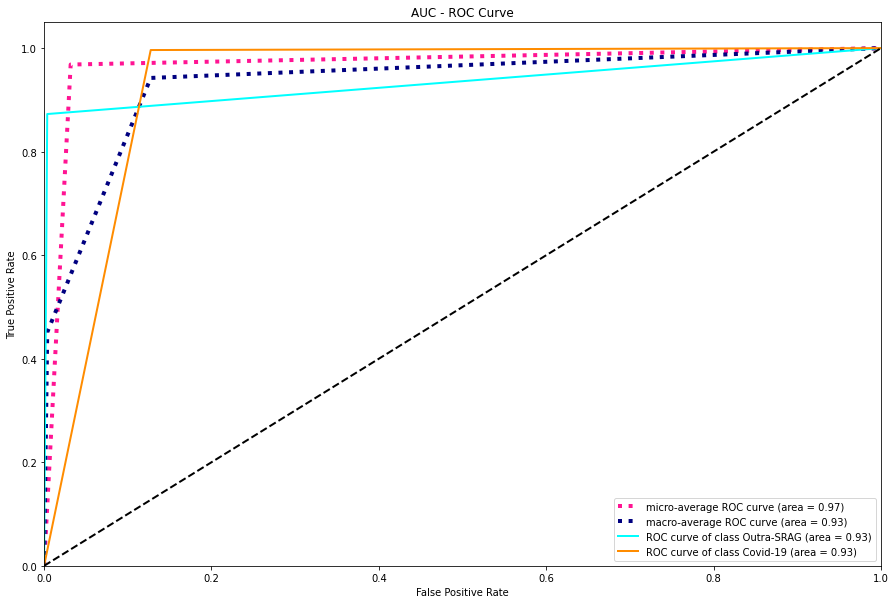

None

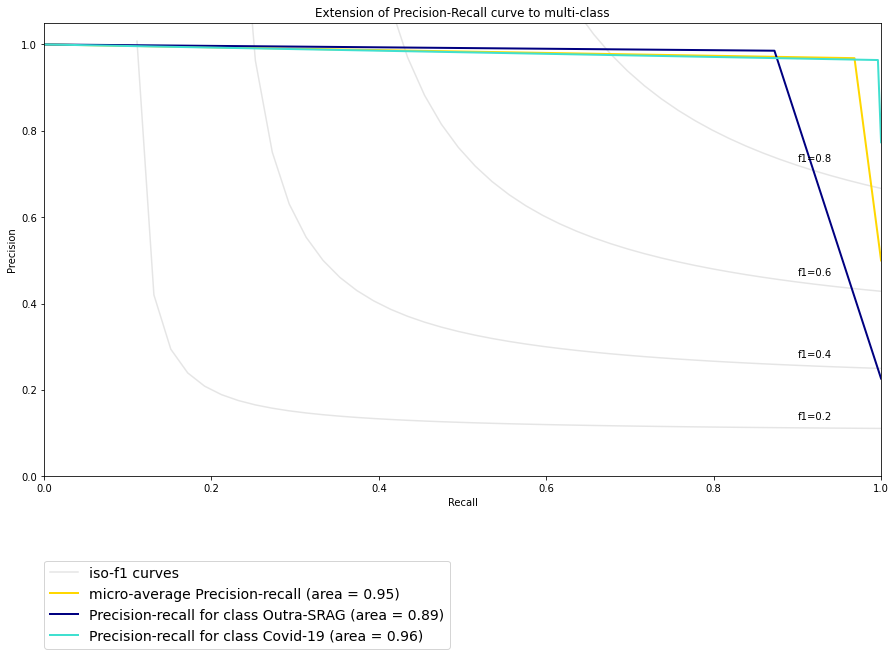

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.93     0.89       0.99    0.87         1.00   
1    Covid-19  0.98     0.93     0.96       0.96    1.00         0.87   
2       Média  0.96     0.93     0.92       0.98    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2347 - acc: 0.9596 - precision_m: 0.9596 - recall_m: 0.9596 - f1_m: 0.9596 - auc: 0.9824
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2101 - acc: 0.9665 - precision_m: 0.9665 - recall_m: 0.9665 - f1_m: 0.9665 - auc: 0.9849
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2052 - acc: 0.9683 - precision_m: 0.9683 - recall_m: 0.9683 - f1_m: 0.9683 - auc: 0.9855
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2030 - acc: 0.9692 - precision_m: 0.9692 - recall_m: 0.9

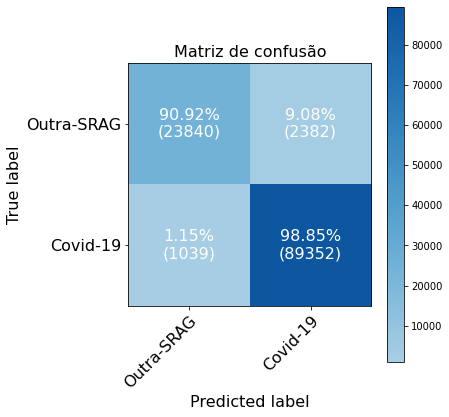

None

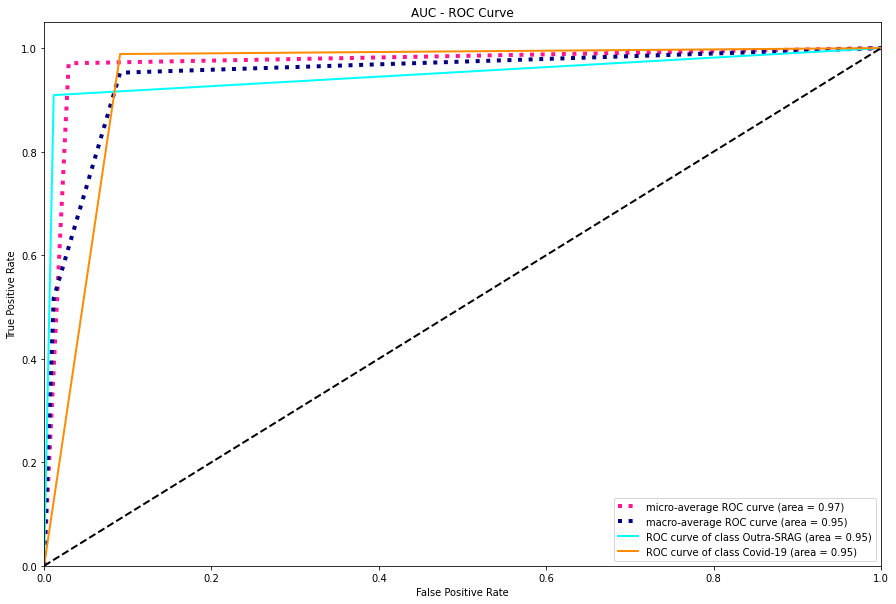

None

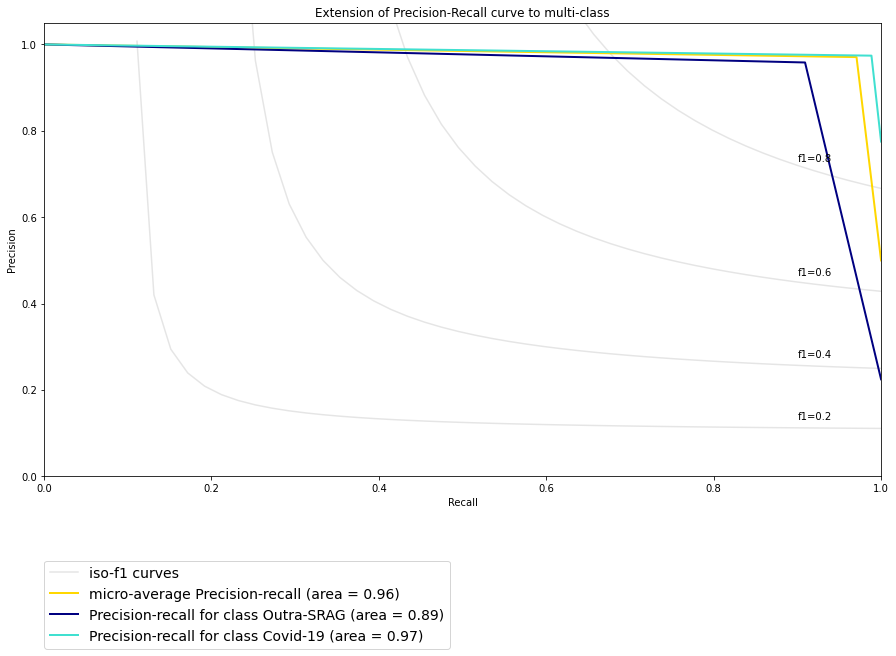

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.96    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.93       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.3411 - acc: 0.9117 - precision_m: 0.9117 - recall_m: 0.9117 - f1_m: 0.9117 - auc: 0.9611
Epoch 2/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2183 - acc: 0.9646 - precision_m: 0.9646 - recall_m: 0.9646 - f1_m: 0.9646 - auc: 0.9841
Epoch 3/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2104 - acc: 0.9677 - precision_m: 0.9677 - recall_m: 0.9677 - f1_m: 0.9677 - auc: 0.9850
Epoch 4/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2067 - acc: 0.9692 - precision_m: 0.9692 - recall_m: 0.9

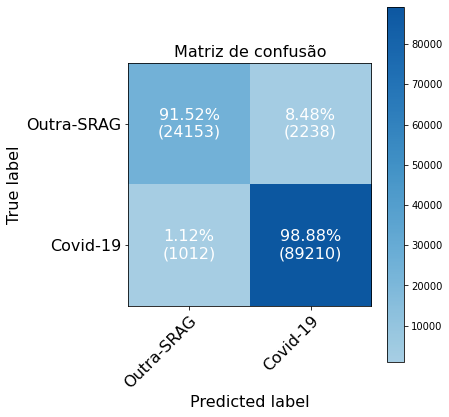

None

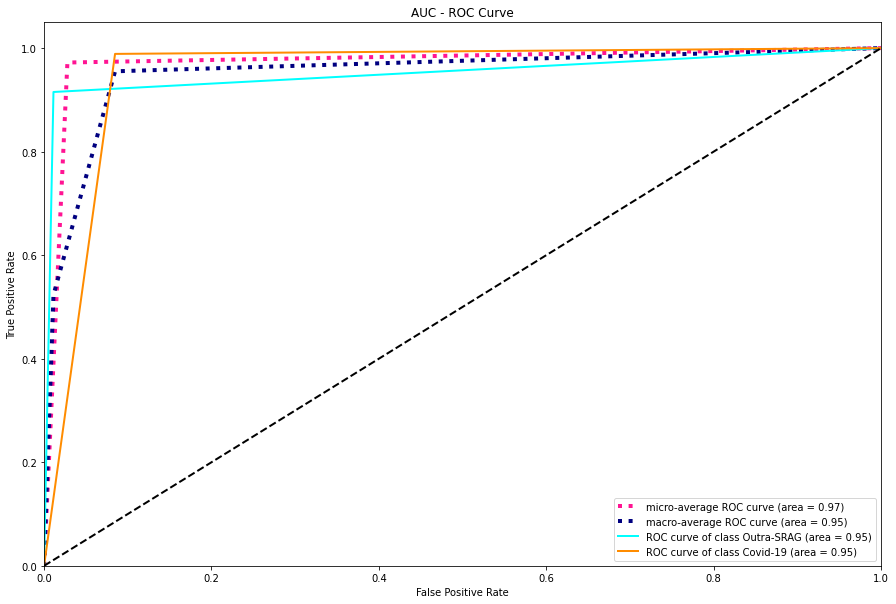

None

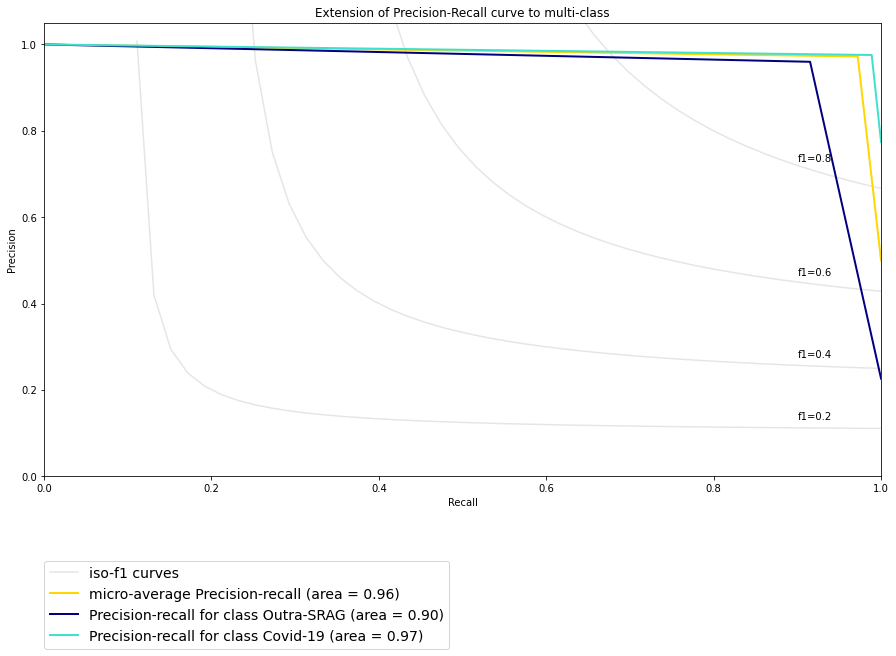

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.94     0.95     0.90       0.96    0.92         0.99   
1    Covid-19  0.98     0.95     0.97       0.98    0.99         0.92   
2       Média  0.96     0.95     0.94       0.97    0.96         0.96   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2356 - acc: 0.9592 - precision_m: 0.9592 - recall_m: 0.9592 - f1_m: 0.9592 - auc: 0.9822
Epoch 2/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2084 - acc: 0.9670 - precision_m: 0.9670 - recall_m: 0.9670 - f1_m: 0.9670 - auc: 0.9848
Epoch 3/104
12378/12378 [==============================] - 20s 2ms/step - loss: 0.2040 - acc: 0.9688 - precision_m: 0.9688 - recall_m: 0.9688 - f1_m: 0.9688 - auc: 0.9853
Epoch 4/104
12378/12378 [==============================] - 21s 2ms/step - loss: 0.2024 - acc: 0.9693 - precision_m: 0.9693 - recall_m: 0.9

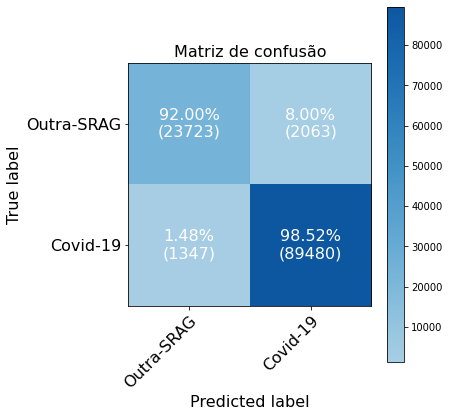

None

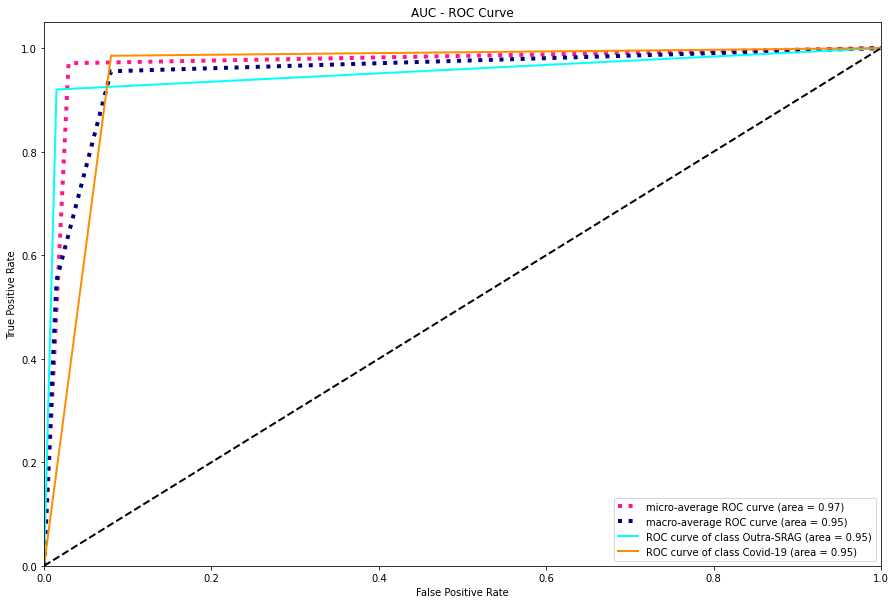

None

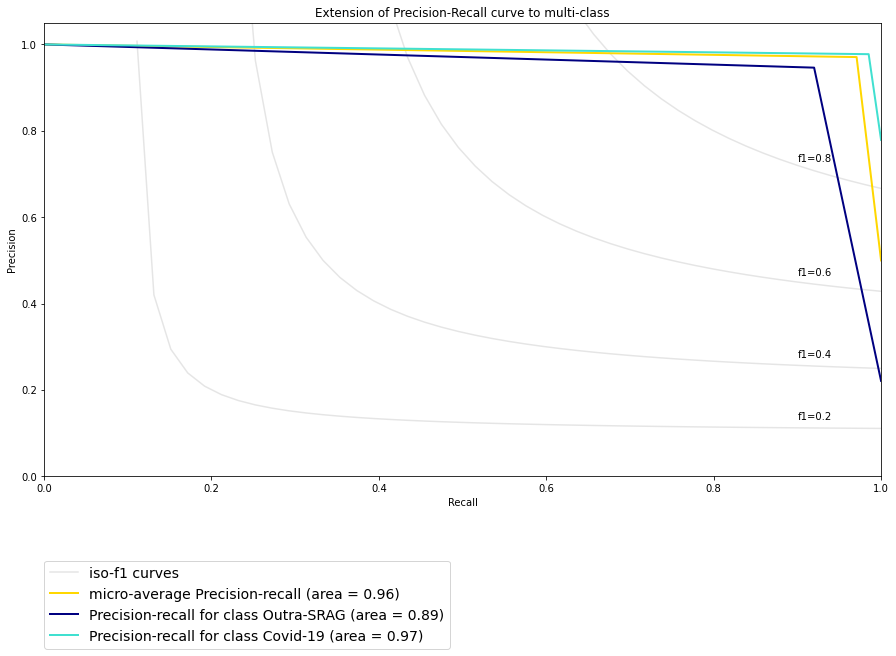

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.95    0.92         0.99   
1    Covid-19  0.98     0.95     0.97       0.98    0.99         0.92   
2       Média  0.96     0.95     0.93       0.96    0.96         0.96   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.5544 - acc: 0.8086 - precision_m: 0.8086 - recall_m: 0.8086 - f1_m: 0.8086 - auc: 0.8406
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2178 - acc: 0.9632 - precision_m: 0.9632 - recall_m: 0.9632 - f1_m: 0.9632 - auc: 0.9839
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2076 - acc: 0.9674 - precision_m: 0.9674 - recall_m: 0.9674 - f1_m: 0.9674 - auc: 0.9850
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2035 - acc: 0.9690 - precision_m: 0.9690 - recall_m: 0.9

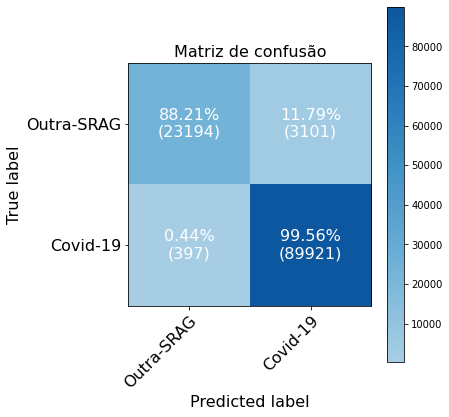

None

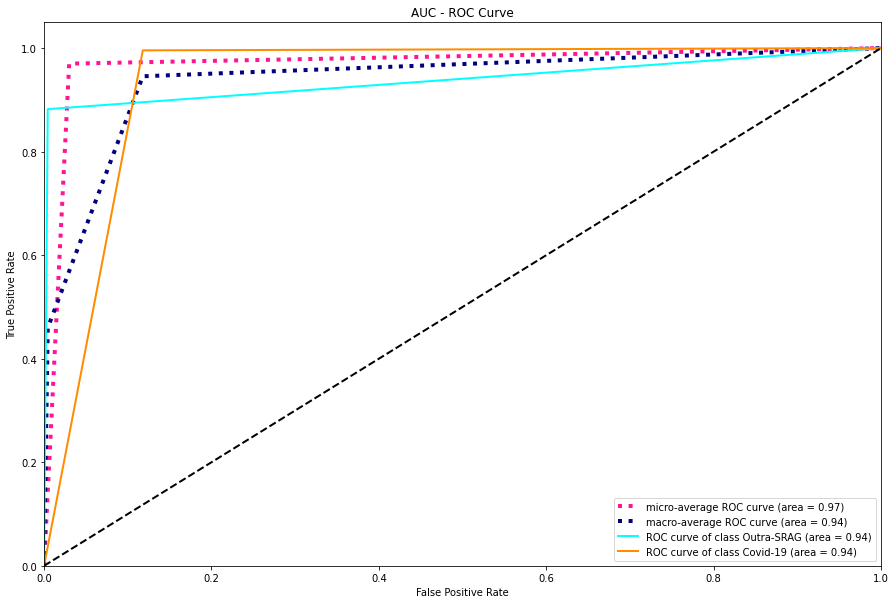

None

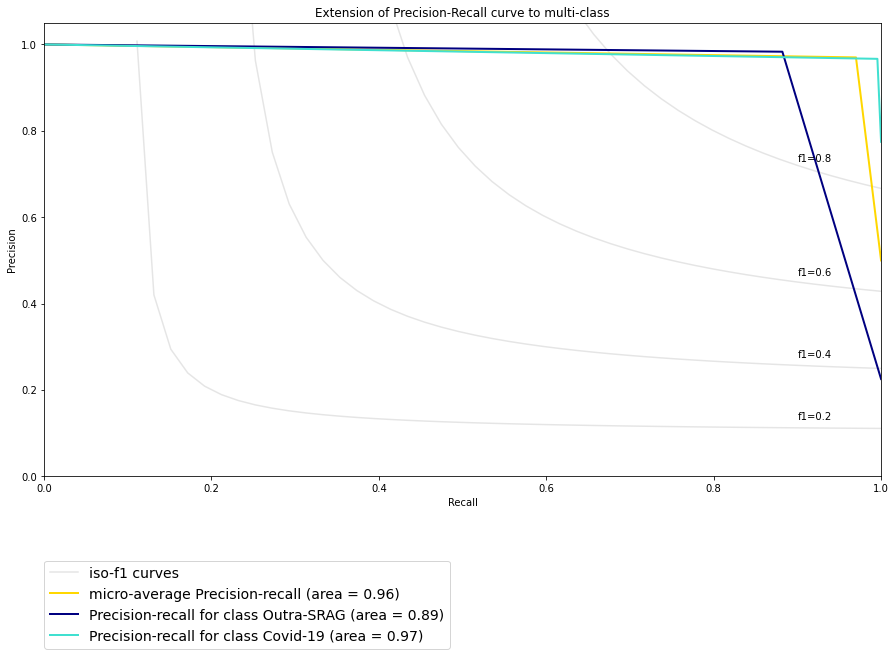

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.94     0.89       0.98    0.88         1.00   
1    Covid-19  0.98     0.94     0.97       0.97    1.00         0.88   
2       Média  0.96     0.94     0.93       0.98    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2883 - acc: 0.9368 - precision_m: 0.9368 - recall_m: 0.9368 - f1_m: 0.9368 - auc: 0.9752
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2098 - acc: 0.9667 - precision_m: 0.9667 - recall_m: 0.9667 - f1_m: 0.9667 - auc: 0.9849
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2047 - acc: 0.9685 - precision_m: 0.9685 - recall_m: 0.9685 - f1_m: 0.9685 - auc: 0.9856
Epoch 4/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2022 - acc: 0.9690 - precision_m: 0.9690 - recall_m: 0.9

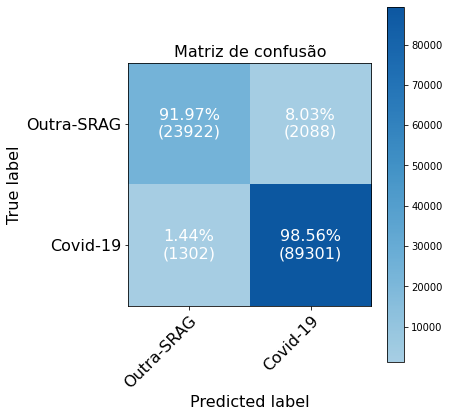

None

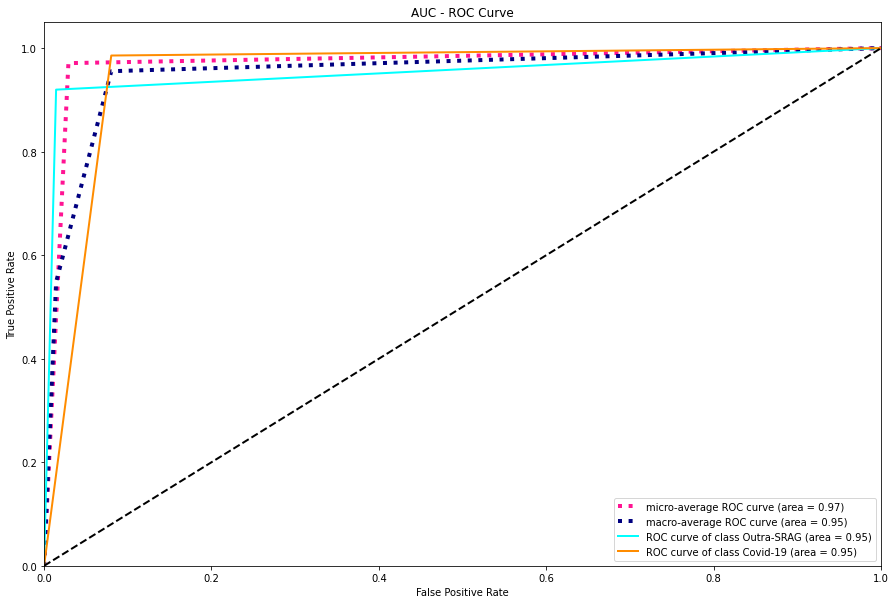

None

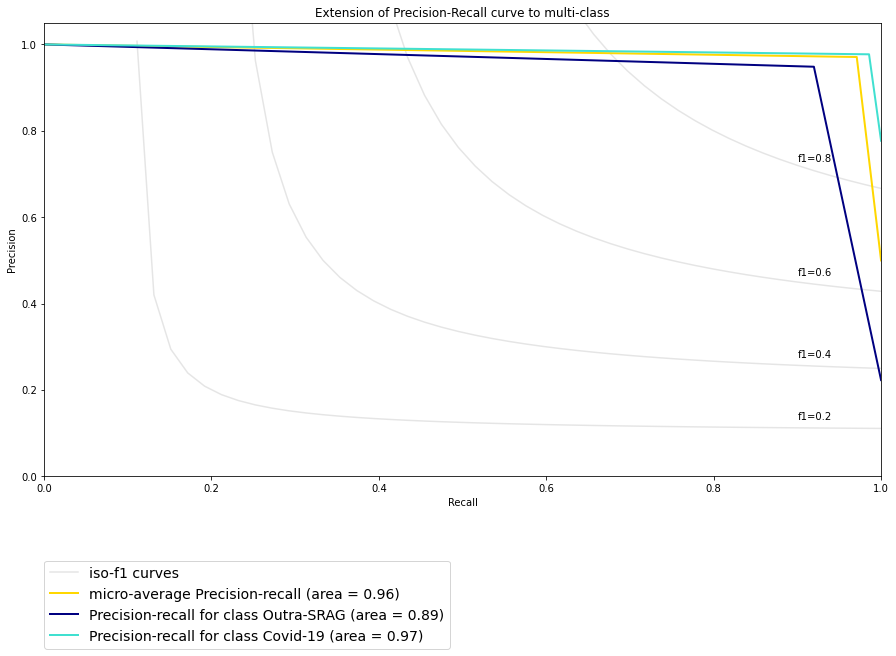

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.95    0.92         0.99   
1    Covid-19  0.98     0.95     0.97       0.98    0.99         0.92   
2       Média  0.96     0.95     0.93       0.96    0.96         0.96   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2354 - acc: 0.9595 - precision_m: 0.9595 - recall_m: 0.9595 - f1_m: 0.9595 - auc: 0.9822
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2083 - acc: 0.9669 - precision_m: 0.9669 - recall_m: 0.9669 - f1_m: 0.9669 - auc: 0.9847
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2036 - acc: 0.9687 - precision_m: 0.9687 - recall_m: 0.9687 - f1_m: 0.9687 - auc: 0.9853
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2012 - acc: 0.9691 - precision_m: 0.9691 - recall_m: 0.9

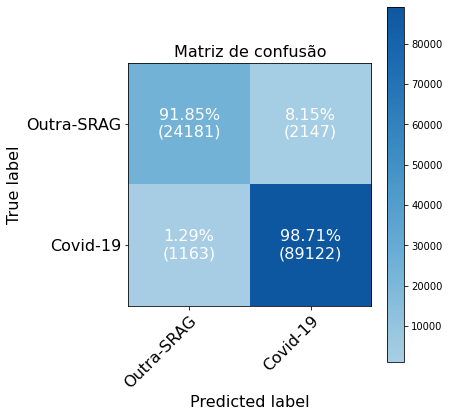

None

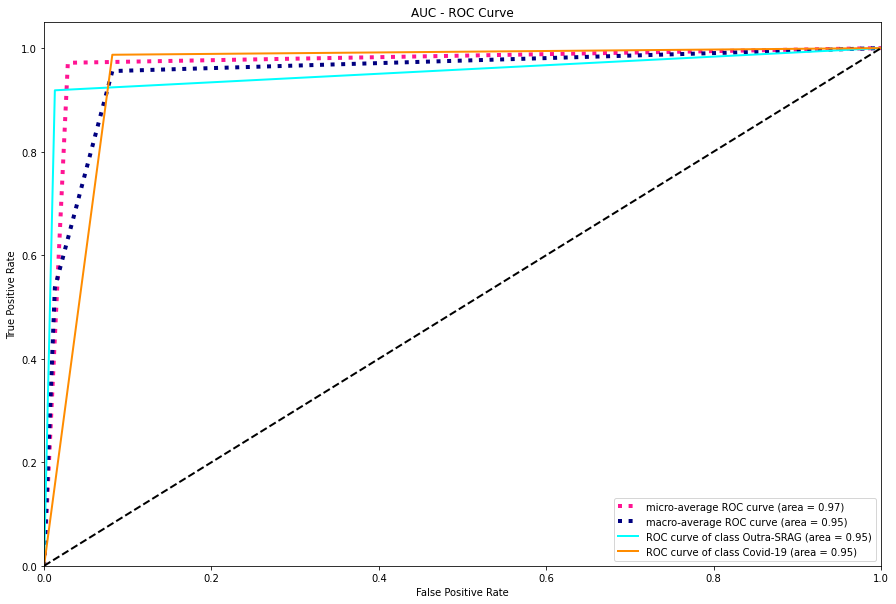

None

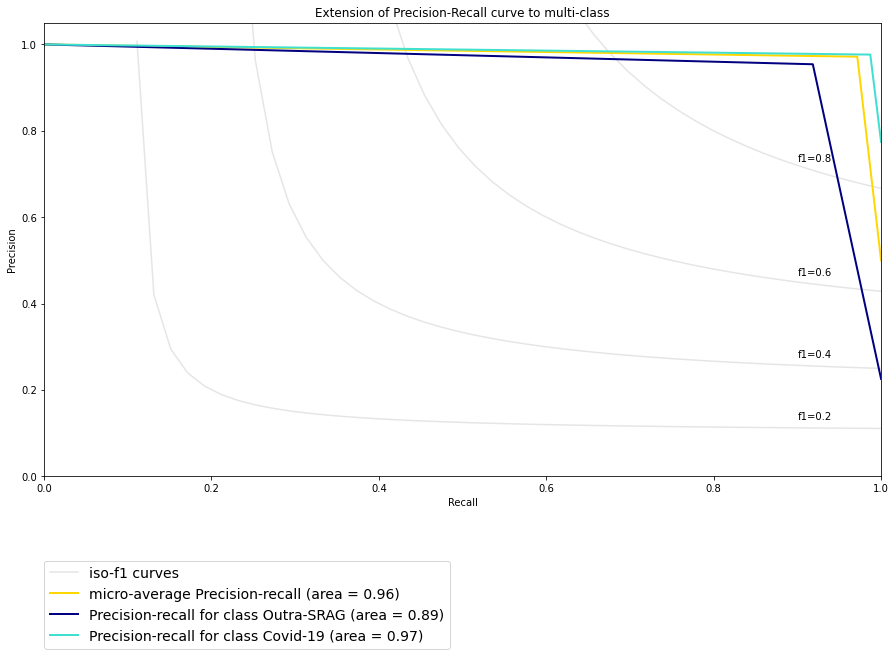

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.94     0.95     0.89       0.95    0.92         0.99   
1    Covid-19  0.98     0.95     0.97       0.98    0.99         0.92   
2       Média  0.96     0.95     0.93       0.96    0.96         0.96   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2376 - acc: 0.9598 - precision_m: 0.9598 - recall_m: 0.9598 - f1_m: 0.9598 - auc: 0.9819
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2098 - acc: 0.9678 - precision_m: 0.9678 - recall_m: 0.9678 - f1_m: 0.9678 - auc: 0.9847
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2064 - acc: 0.9693 - precision_m: 0.9693 - recall_m: 0.9693 - f1_m: 0.9693 - auc: 0.9850
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2051 - acc: 0.9697 - precision_m: 0.9697 - recall_m: 0.9

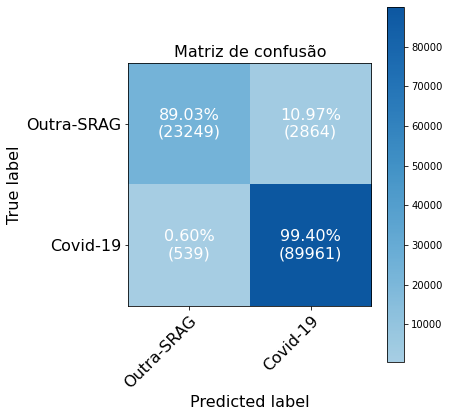

None

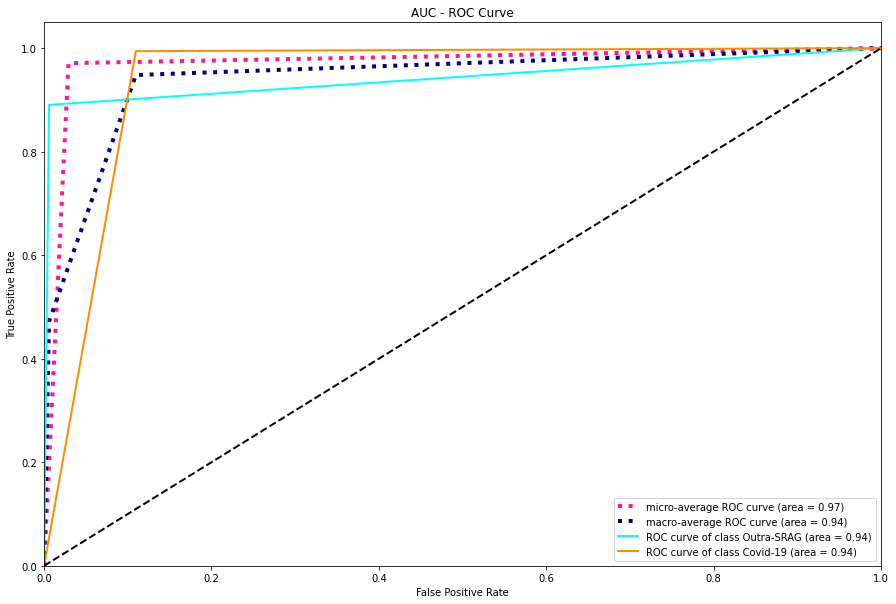

None

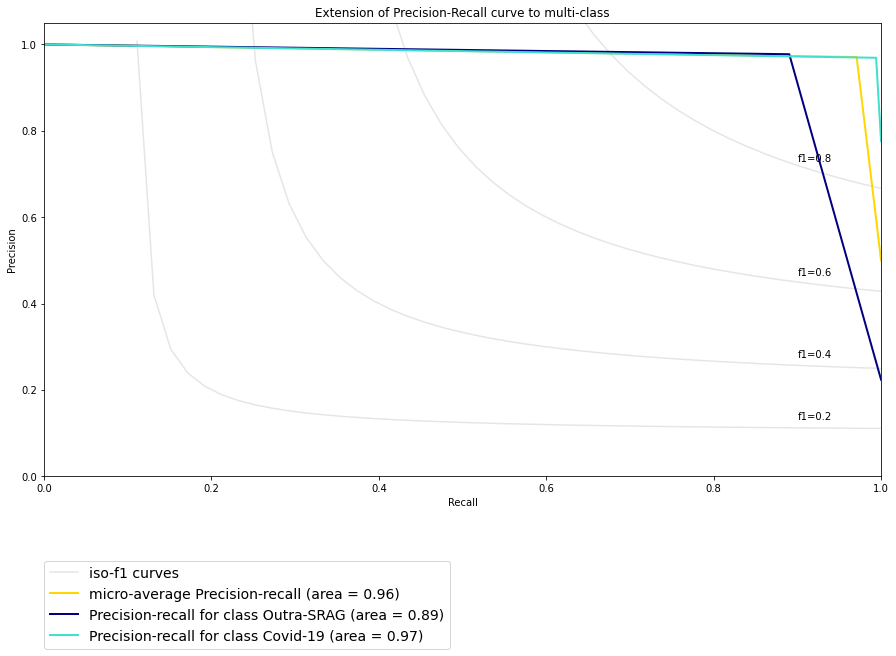

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.94     0.89       0.98    0.89         0.99   
1    Covid-19  0.98     0.94     0.97       0.97    0.99         0.89   
2       Média  0.96     0.94     0.93       0.98    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2364 - acc: 0.9602 - precision_m: 0.9602 - recall_m: 0.9602 - f1_m: 0.9602 - auc: 0.9824
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2107 - acc: 0.9675 - precision_m: 0.9675 - recall_m: 0.9675 - f1_m: 0.9675 - auc: 0.9848
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2068 - acc: 0.9690 - precision_m: 0.9690 - recall_m: 0.9690 - f1_m: 0.9690 - auc: 0.9855
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2048 - acc: 0.9692 - precision_m: 0.9692 - recall_m: 0.9

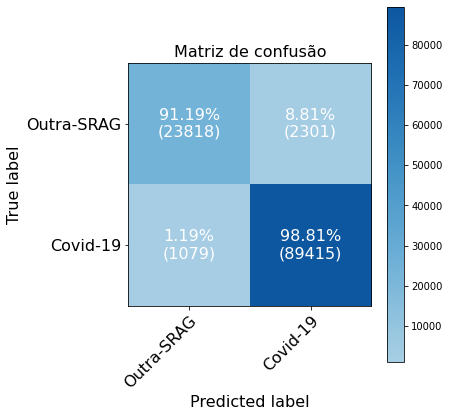

None

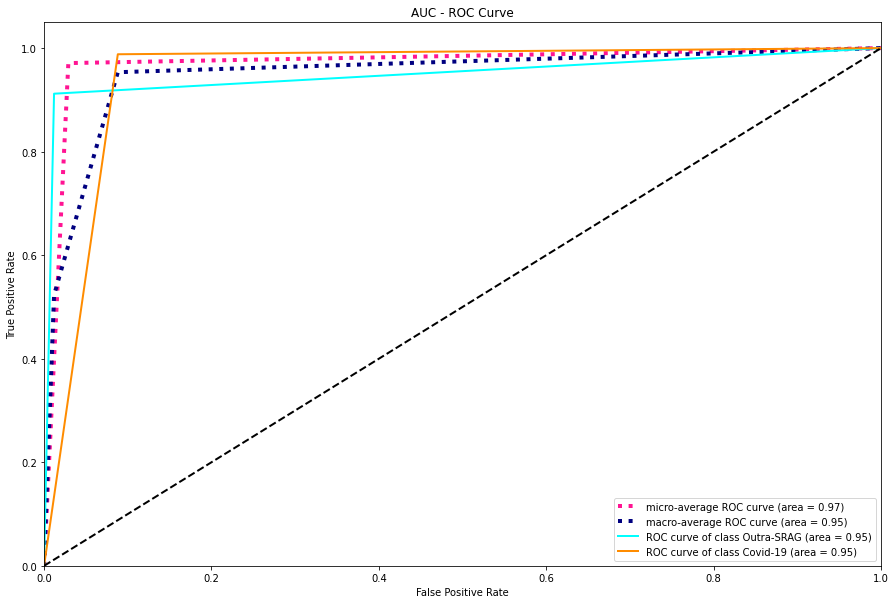

None

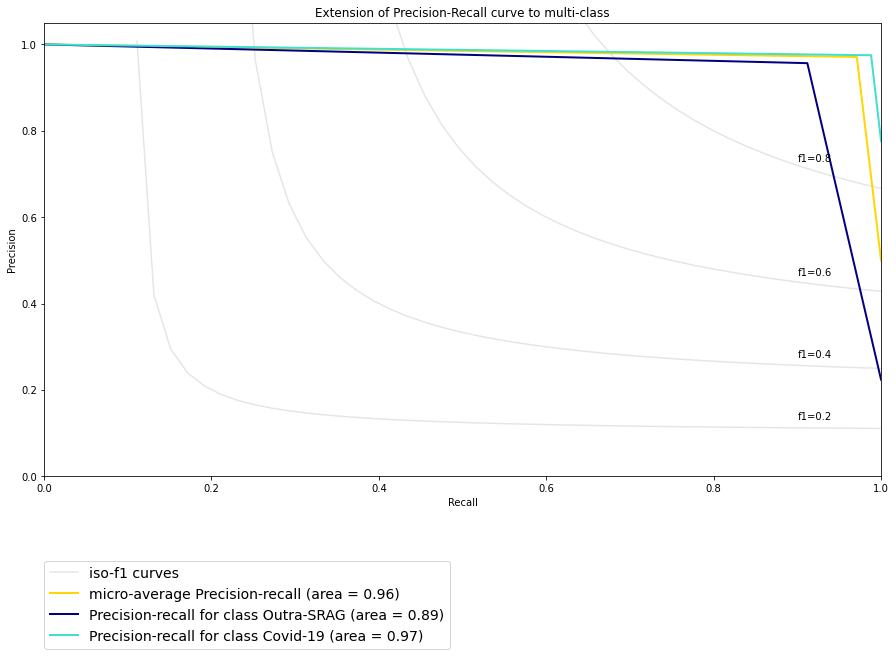

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.96    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.93       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2311 - acc: 0.9609 - precision_m: 0.9609 - recall_m: 0.9609 - f1_m: 0.9609 - auc: 0.9830
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2073 - acc: 0.9675 - precision_m: 0.9675 - recall_m: 0.9675 - f1_m: 0.9675 - auc: 0.9850
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2042 - acc: 0.9687 - precision_m: 0.9687 - recall_m: 0.9687 - f1_m: 0.9687 - auc: 0.9854
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2026 - acc: 0.9693 - precision_m: 0.9692 - recall_m: 0.9

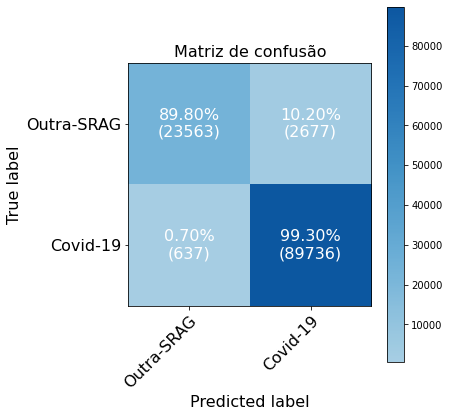

None

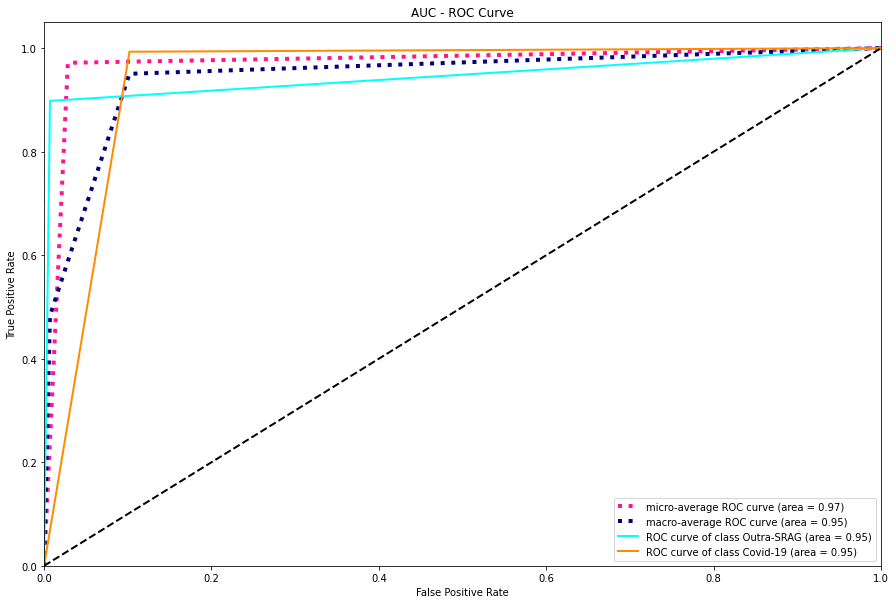

None

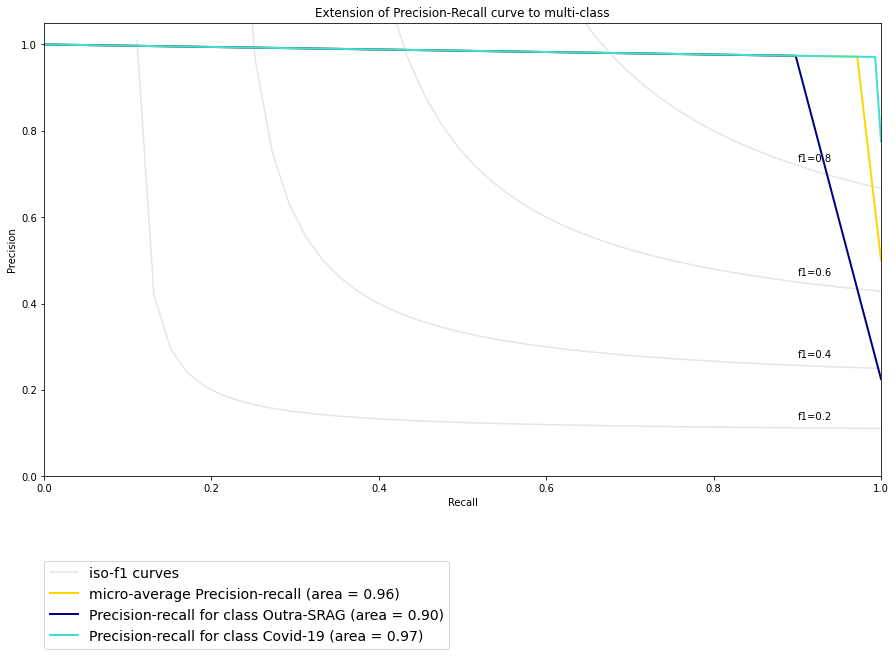

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.90       0.97    0.90         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.90   
2       Média  0.96     0.95     0.94       0.97    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2340 - acc: 0.9600 - precision_m: 0.9600 - recall_m: 0.9600 - f1_m: 0.9600 - auc: 0.9826
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2067 - acc: 0.9676 - precision_m: 0.9676 - recall_m: 0.9676 - f1_m: 0.9676 - auc: 0.9850
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2031 - acc: 0.9690 - precision_m: 0.9690 - recall_m: 0.9690 - f1_m: 0.9690 - auc: 0.9854
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2018 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9

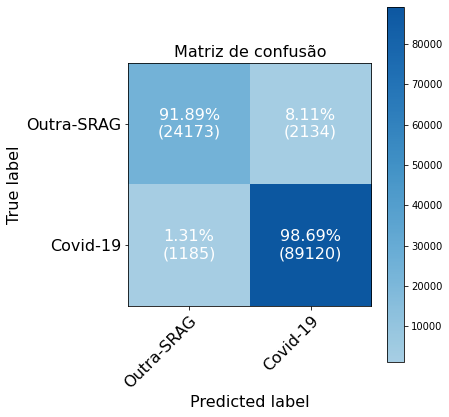

None

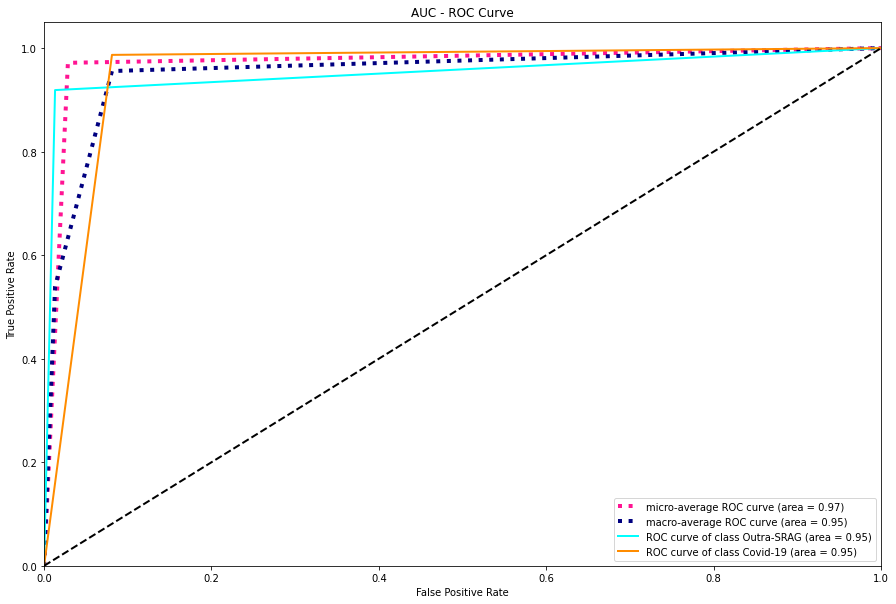

None

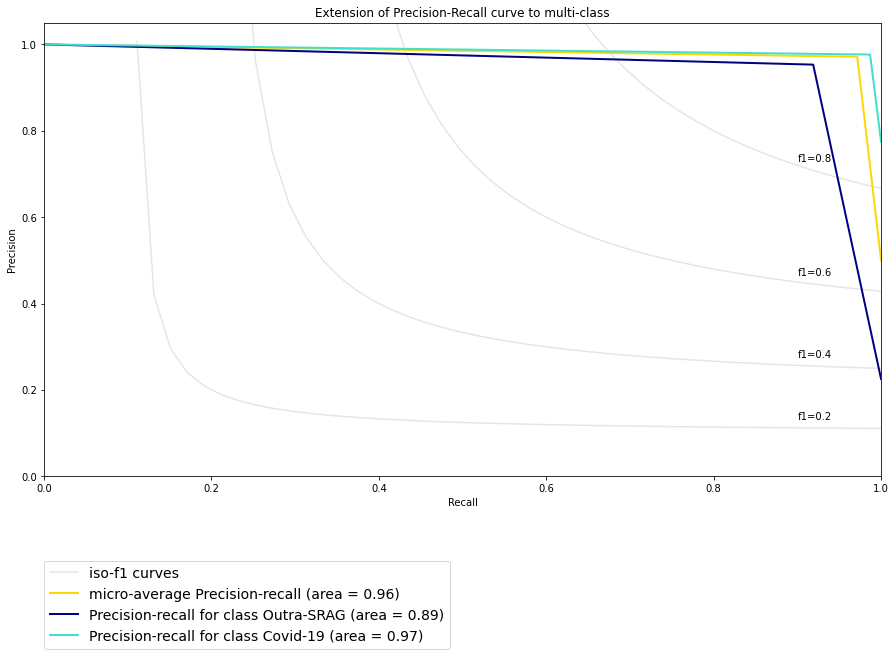

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.94     0.95     0.89       0.95    0.92         0.99   
1    Covid-19  0.98     0.95     0.97       0.98    0.99         0.92   
2       Média  0.96     0.95     0.93       0.96    0.96         0.96   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2421 - acc: 0.9574 - precision_m: 0.9574 - recall_m: 0.9574 - f1_m: 0.9574 - auc: 0.9815
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2109 - acc: 0.9658 - precision_m: 0.9658 - recall_m: 0.9658 - f1_m: 0.9658 - auc: 0.9850
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2047 - acc: 0.9682 - precision_m: 0.9682 - recall_m: 0.9682 - f1_m: 0.9682 - auc: 0.9861
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2019 - acc: 0.9690 - precision_m: 0.9690 - recall_m: 0.9

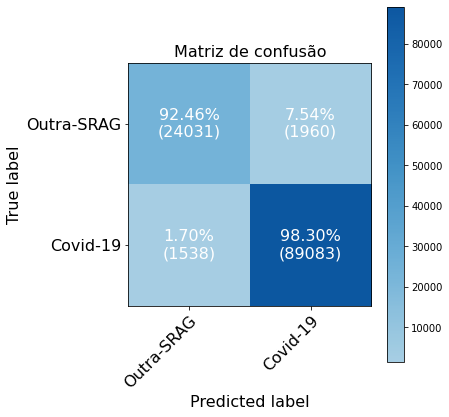

None

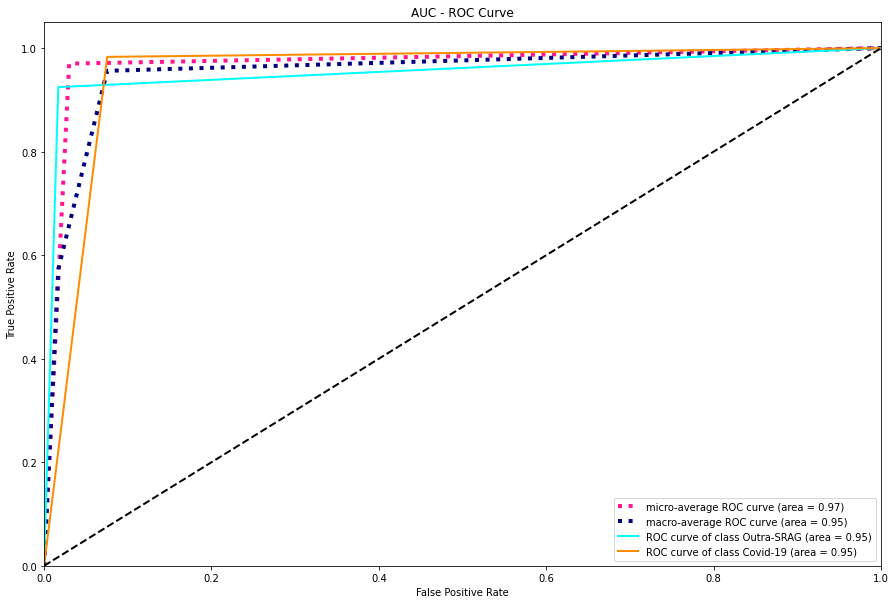

None

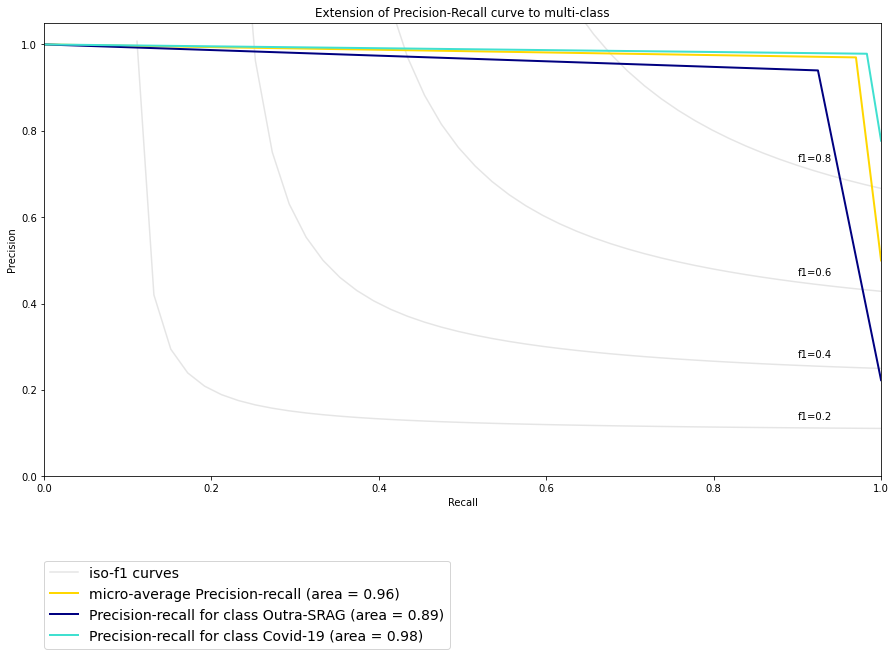

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.94    0.92         0.98   
1    Covid-19  0.98     0.95     0.98       0.98    0.98         0.92   
2       Média  0.96     0.95     0.94       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 2ms/step - loss: 0.2369 - acc: 0.9600 - precision_m: 0.9600 - recall_m: 0.9600 - f1_m: 0.9600 - auc: 0.9821
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2108 - acc: 0.9673 - precision_m: 0.9673 - recall_m: 0.9673 - f1_m: 0.9673 - auc: 0.9851
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2064 - acc: 0.9688 - precision_m: 0.9688 - recall_m: 0.9688 - f1_m: 0.9688 - auc: 0.9860
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2034 - acc: 0.9692 - precision_m: 0.9692 - recall_m: 0.9

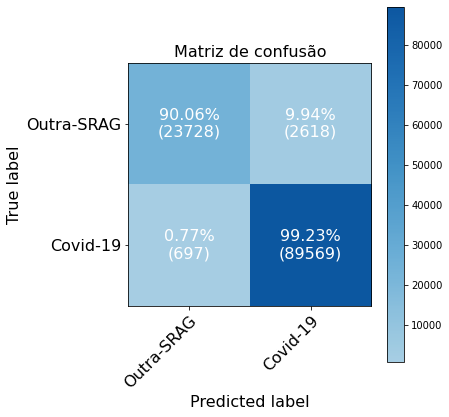

None

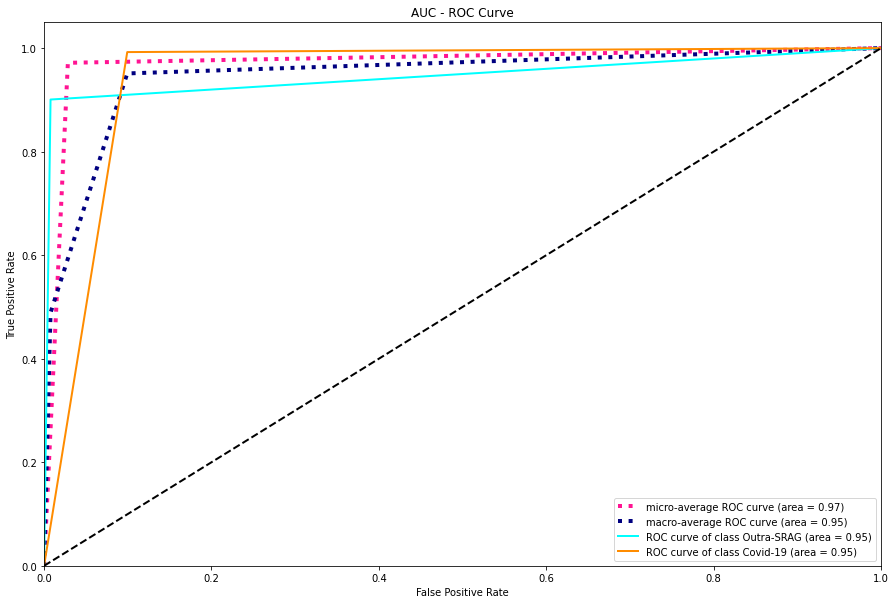

None

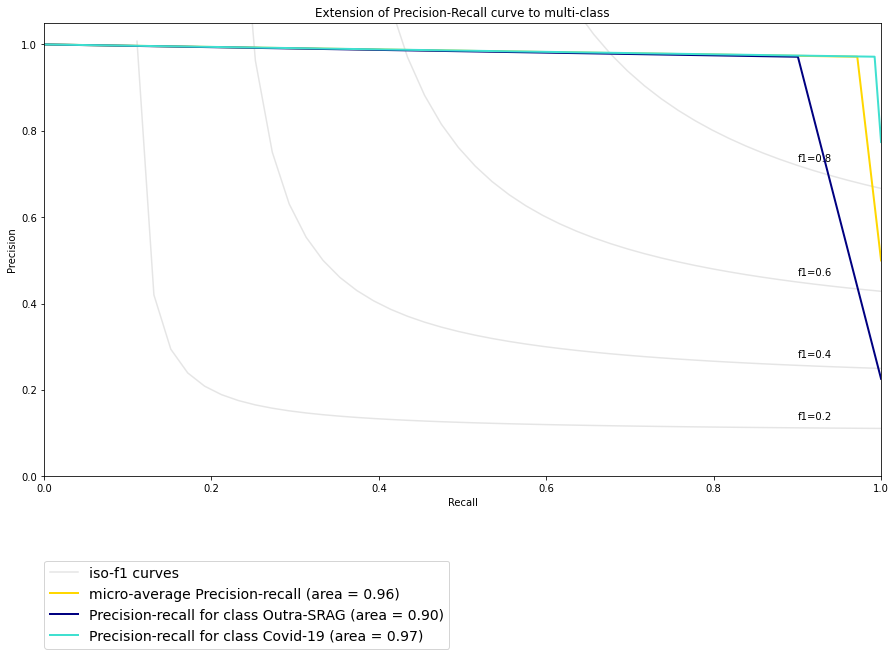

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.90       0.97    0.90         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.90   
2       Média  0.96     0.95     0.94       0.97    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2427 - acc: 0.9593 - precision_m: 0.9593 - recall_m: 0.9593 - f1_m: 0.9593 - auc: 0.9816
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2117 - acc: 0.9671 - precision_m: 0.9671 - recall_m: 0.9671 - f1_m: 0.9671 - auc: 0.9849
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2067 - acc: 0.9686 - precision_m: 0.9686 - recall_m: 0.9686 - f1_m: 0.9686 - auc: 0.9860
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2034 - acc: 0.9692 - precision_m: 0.9692 - recall_m: 0.9

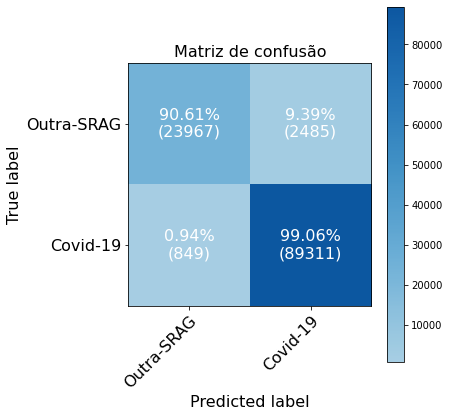

None

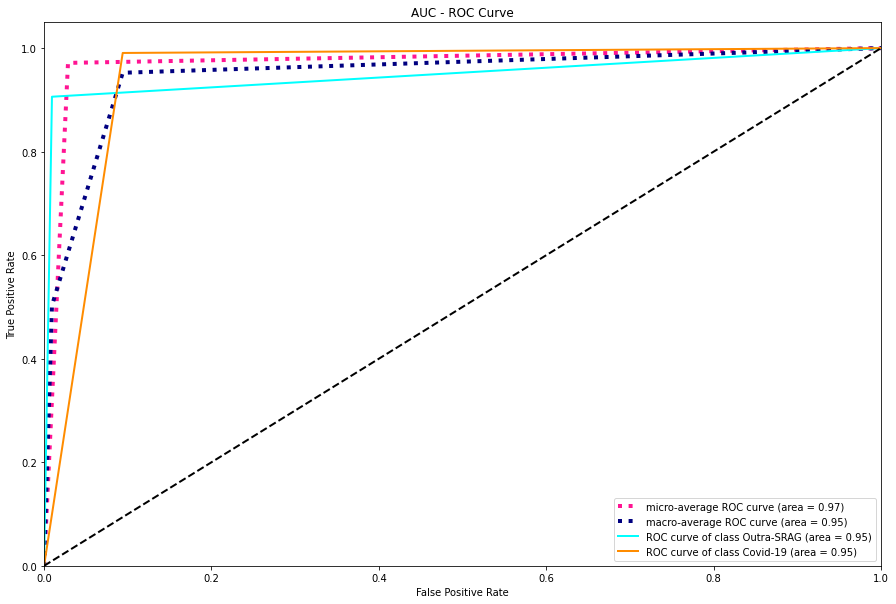

None

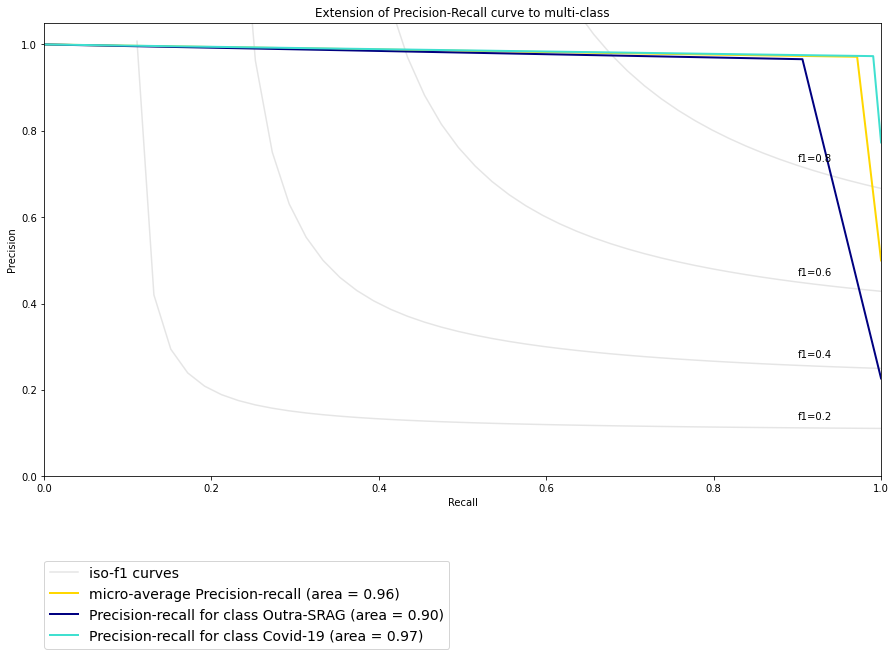

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.90       0.97    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.94       0.97    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2553 - acc: 0.9552 - precision_m: 0.9552 - recall_m: 0.9552 - f1_m: 0.9552 - auc: 0.9801
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2113 - acc: 0.9667 - precision_m: 0.9667 - recall_m: 0.9667 - f1_m: 0.9667 - auc: 0.9847
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2054 - acc: 0.9685 - precision_m: 0.9685 - recall_m: 0.9685 - f1_m: 0.9685 - auc: 0.9854
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2038 - acc: 0.9690 - precision_m: 0.9690 - recall_m: 0.9

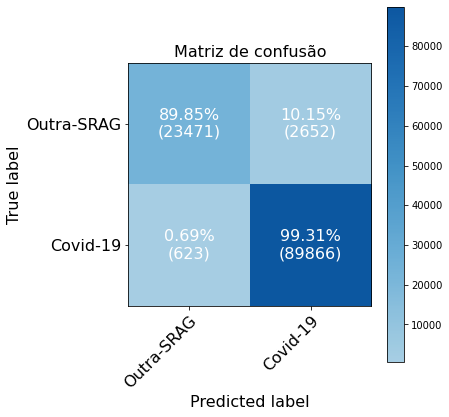

None

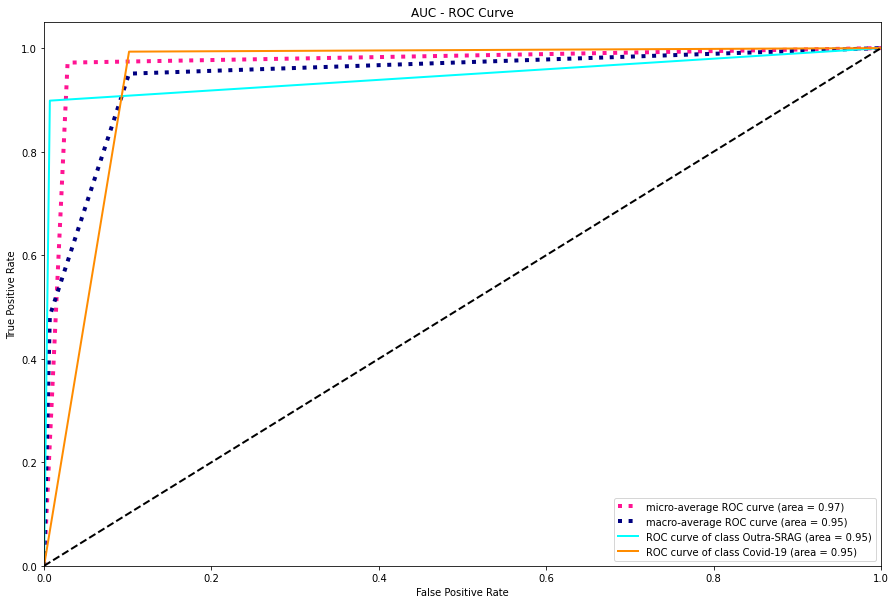

None

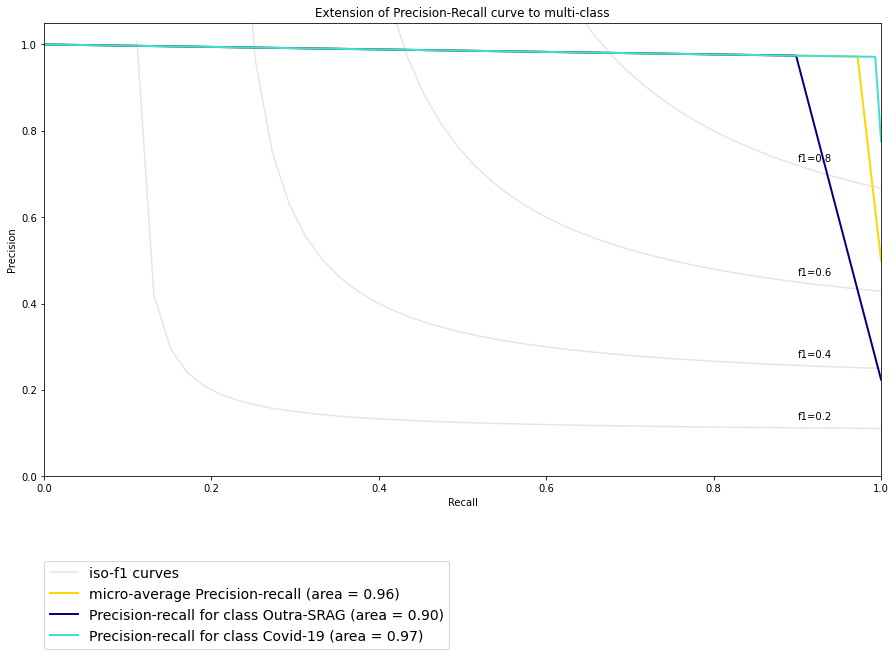

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.90       0.97    0.90         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.90   
2       Média  0.96     0.95     0.94       0.97    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2326 - acc: 0.9602 - precision_m: 0.9602 - recall_m: 0.9602 - f1_m: 0.9602 - auc: 0.9825
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2069 - acc: 0.9674 - precision_m: 0.9674 - recall_m: 0.9674 - f1_m: 0.9674 - auc: 0.9849
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2033 - acc: 0.9689 - precision_m: 0.9689 - recall_m: 0.9689 - f1_m: 0.9689 - auc: 0.9853
Epoch 4/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2019 - acc: 0.9691 - precision_m: 0.9691 - recall_m: 0.9

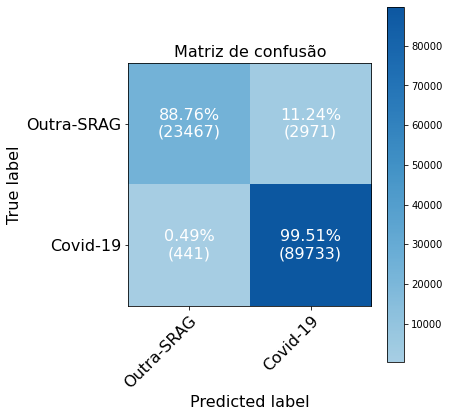

None

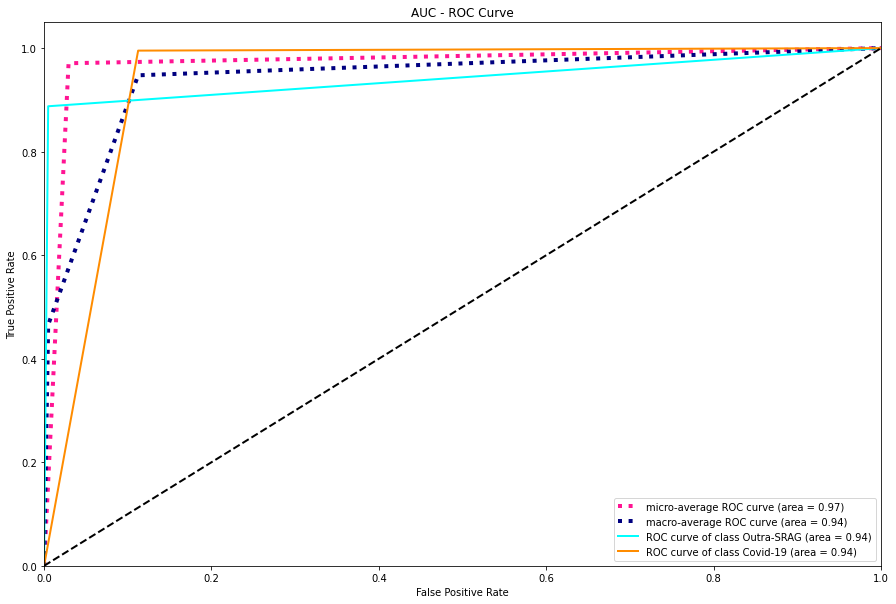

None

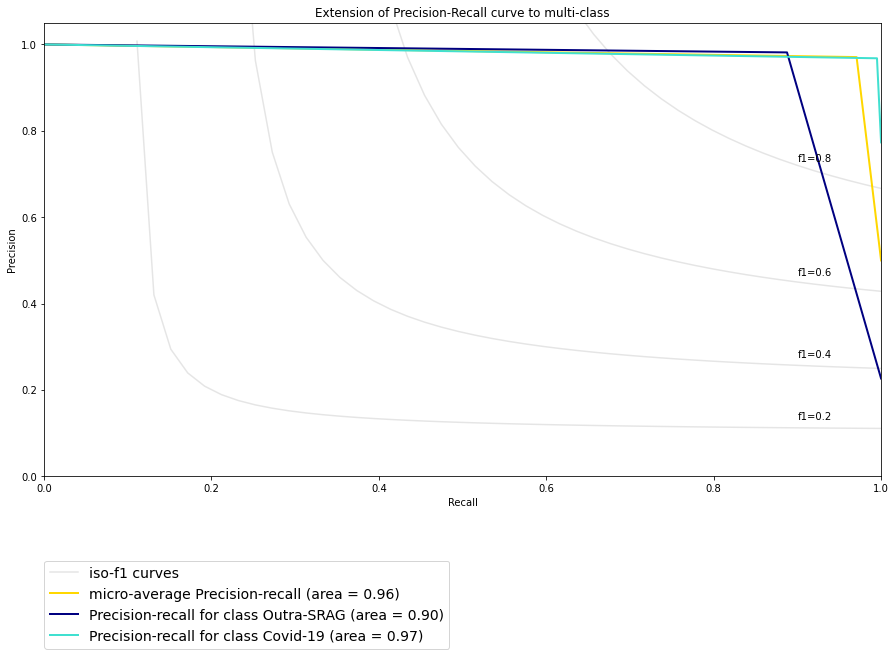

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.94     0.90       0.98    0.89         1.00   
1    Covid-19  0.98     0.94     0.97       0.97    1.00         0.89   
2       Média  0.96     0.94     0.94       0.98    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/104
12378/12378 [==============================] - 19s 1ms/step - loss: 0.2334 - acc: 0.9602 - precision_m: 0.9602 - recall_m: 0.9602 - f1_m: 0.9602 - auc: 0.9825
Epoch 2/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2067 - acc: 0.9678 - precision_m: 0.9678 - recall_m: 0.9678 - f1_m: 0.9678 - auc: 0.9853
Epoch 3/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2037 - acc: 0.9689 - precision_m: 0.9689 - recall_m: 0.9689 - f1_m: 0.9689 - auc: 0.9858
Epoch 4/104
12378/12378 [==============================] - 18s 1ms/step - loss: 0.2023 - acc: 0.9693 - precision_m: 0.9693 - recall_m: 0.9

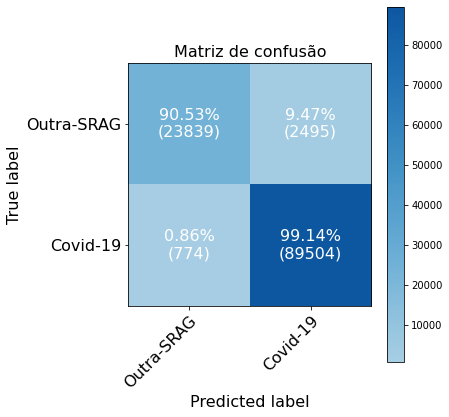

None

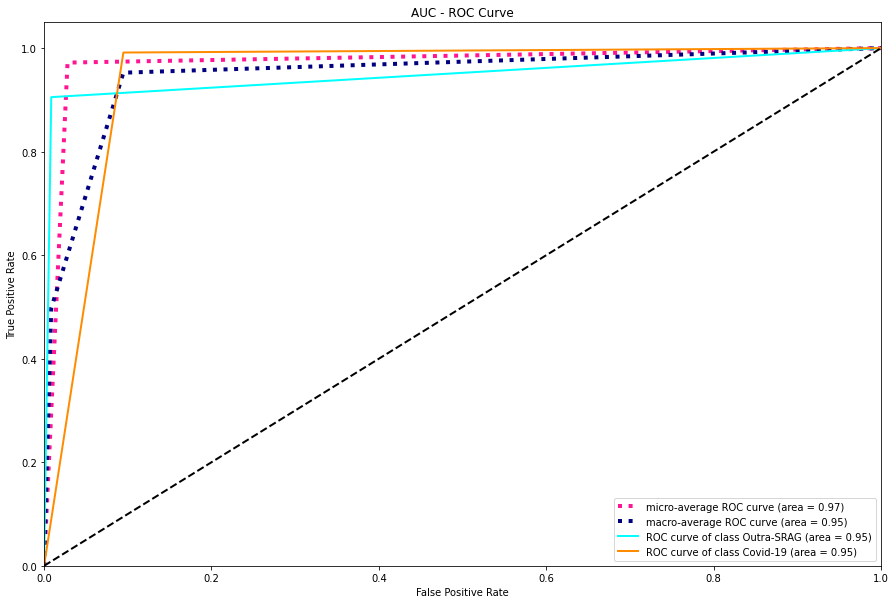

None

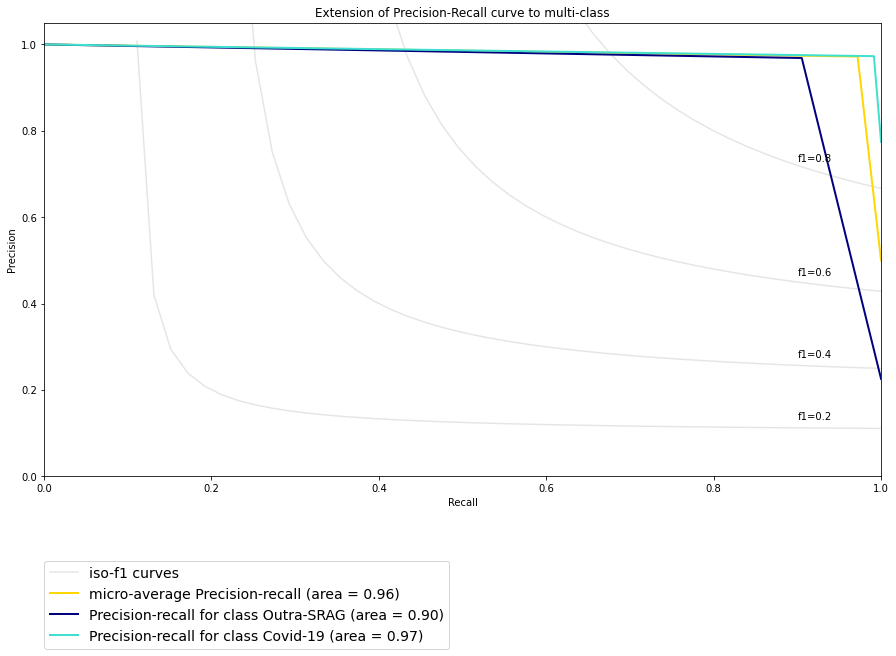

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.94     0.95     0.90       0.97    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.94       0.97    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  


In [26]:
x = df.select(x_cols).toPandas()
y = df.select(y_cols).toPandas()

all_metrics = []
seed = 0
i = 0

kfold = KFold(n_splits=20, shuffle=True, random_state=seed)
for train, test in kfold.split(x, y):

    x_scaler = MinMaxScaler(feature_range=(0, 1))
#     y_scaler = MinMaxScaler(feature_range=(0, 1))

    x_train = x_scaler.fit_transform(x.values[train])
    y_train = tf.keras.utils.to_categorical(y.values[train])
#     y_train = y_scaler.fit_transform(y.values[train])

    # Load model
    model = mlp_model((x_train.shape[1],))
    # Fit the model
    model.fit(x_train, y_train, epochs=104, batch_size=179)

    # evaluate the model
    x_test = x_scaler.transform(x.values[test])
    y_pred = model.predict(x_test)
    y_true = y.values[test]
    y_pred = np.argmax(y_pred, axis=1)

    out = f'{mlp_kfold}/{i}fold'
    pathlib.Path(out).mkdir(parents=True, exist_ok=True)

    lbs = ['Outra-SRAG', 'Covid-19']
    pai.plot_graphics(y_true, y_pred, class_names=lbs, save_path=out)
    metrics = pai.get_metrics(y_true.ravel(), y_pred, class_names=lbs, save_path=out)
    print(metrics)
    all_metrics.append(metrics)
    i+=1

Média e desvio padrão dos k-folds

In [27]:
aux = []
for target in all_metrics[0].index[:-1]:
    m = [
        metrics.loc[target].rename(
            f"{metrics.loc[target, 'Classes']} {i}-fold"
        ).drop('Classes')
        for i, metrics in enumerate(all_metrics)
    ]

    df = pd.DataFrame(m)
    df.loc['Avg'] = df.iloc[:5].apply(lambda x: x.mean()).round(2)
    df.loc['Std'] = df.iloc[:5].apply(lambda x: x.std()).round(2)
    display(df)
    df.to_csv(f'{mlp_kfold}/{all_metrics[0].loc[target].Classes}_metrics.csv')

F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
Outra-SRAG 0-fold   0.93     0.95     0.89       0.96    0.91         0.99   
Outra-SRAG 1-fold   0.94     0.95     0.89       0.96    0.91         0.99   
Outra-SRAG 2-fold   0.94     0.95     0.90       0.97    0.90         0.99   
Outra-SRAG 3-fold   0.93     0.93     0.89       0.99    0.87         1.00   
Outra-SRAG 4-fold   0.93     0.95     0.89       0.96    0.91         0.99   
Outra-SRAG 5-fold   0.94     0.95     0.90       0.96    0.92         0.99   
Outra-SRAG 6-fold   0.93     0.95     0.89       0.95    0.92         0.99   
Outra-SRAG 7-fold   0.93     0.94     0.89       0.98    0.88         1.00   
Outra-SRAG 8-fold   0.93     0.95     0.89       0.95    0.92         0.99   
Outra-SRAG 9-fold   0.94     0.95     0.89       0.95    0.92         0.99   
Outra-SRAG 10-fold  0.93     0.94     0.89       0.98    0.89         0.99   
Outra-SRAG 11-fold  0.93     0.95     0.89       0.96    0.91         0.99   
Outra-SRAG 12-fold  0.93     0.95     0.90       0.97    0.90         0.99   
Outra-SRAG 13-fold  0.94     0.95     0.89       0.95    0.92         0.99   
Outra-SRAG 14-fold  0.93     0.95     0.89       0.94    0.92         0.98   
Outra-SRAG 15-fold  0.93     0.95     0.90       0.97    0.90         0.99   
Outra-SRAG 16-fold  0.93     0.95     0.90       0.97    0.91         0.99   
Outra-SRAG 17-fold  0.93     0.95     0.90       0.97    0.90         0.99   
Outra-SRAG 18-fold  0.93     0.94     0.90       0.98    0.89         1.00   
Outra-SRAG 19-fold  0.94     0.95     0.90       0.97    0.91         0.99   
Avg                 0.93     0.95     0.89       0.97    0.90         0.99   
Std                 0.01     0.01     0.00       0.01    0.02         0.00   

                    Accuracy  
Outra-SRAG 0-fold       0.97  
Outra-SRAG 1-fold       0.97  
Outra-SRAG 2-fold       0.97  
Outra-SRAG 3-fold       0.97  
Outra-SRAG 4-fold       0.97  
Outra-SRAG 5-fold       0.97  
Outra-SRAG 6-fold       0.97  
Outra-SRAG 7-fold       0.97  
Outra-SRAG 8-fold       0.97  
Outra-SRAG 9-fold       0.97  
Outra-SRAG 10-fold      0.97  
Outra-SRAG 11-fold      0.97  
Outra-SRAG 12-fold      0.97  
Outra-SRAG 13-fold      0.97  
Outra-SRAG 14-fold      0.97  
Outra-SRAG 15-fold      0.97  
Outra-SRAG 16-fold      0.97  
Outra-SRAG 17-fold      0.97  
Outra-SRAG 18-fold      0.97  
Outra-SRAG 19-fold      0.97  
Avg                     0.97  
Std                     0.00

F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
Covid-19 0-fold   0.98     0.95     0.97       0.97    0.99         0.91   
Covid-19 1-fold   0.98     0.95     0.97       0.97    0.99         0.91   
Covid-19 2-fold   0.98     0.95     0.97       0.97    0.99         0.90   
Covid-19 3-fold   0.98     0.93     0.96       0.96    1.00         0.87   
Covid-19 4-fold   0.98     0.95     0.97       0.97    0.99         0.91   
Covid-19 5-fold   0.98     0.95     0.97       0.98    0.99         0.92   
Covid-19 6-fold   0.98     0.95     0.97       0.98    0.99         0.92   
Covid-19 7-fold   0.98     0.94     0.97       0.97    1.00         0.88   
Covid-19 8-fold   0.98     0.95     0.97       0.98    0.99         0.92   
Covid-19 9-fold   0.98     0.95     0.97       0.98    0.99         0.92   
Covid-19 10-fold  0.98     0.94     0.97       0.97    0.99         0.89   
Covid-19 11-fold  0.98     0.95     0.97       0.97    0.99         0.91   
Covid-19 12-fold  0.98     0.95     0.97       0.97    0.99         0.90   
Covid-19 13-fold  0.98     0.95     0.97       0.98    0.99         0.92   
Covid-19 14-fold  0.98     0.95     0.98       0.98    0.98         0.92   
Covid-19 15-fold  0.98     0.95     0.97       0.97    0.99         0.90   
Covid-19 16-fold  0.98     0.95     0.97       0.97    0.99         0.91   
Covid-19 17-fold  0.98     0.95     0.97       0.97    0.99         0.90   
Covid-19 18-fold  0.98     0.94     0.97       0.97    1.00         0.89   
Covid-19 19-fold  0.98     0.95     0.97       0.97    0.99         0.91   
Avg               0.98     0.95     0.97       0.97    0.99         0.90   
Std               0.00     0.01     0.00       0.00    0.00         0.02   

                  Accuracy  
Covid-19 0-fold       0.97  
Covid-19 1-fold       0.97  
Covid-19 2-fold       0.97  
Covid-19 3-fold       0.97  
Covid-19 4-fold       0.97  
Covid-19 5-fold       0.97  
Covid-19 6-fold       0.97  
Covid-19 7-fold       0.97  
Covid-19 8-fold       0.97  
Covid-19 9-fold       0.97  
Covid-19 10-fold      0.97  
Covid-19 11-fold      0.97  
Covid-19 12-fold      0.97  
Covid-19 13-fold      0.97  
Covid-19 14-fold      0.97  
Covid-19 15-fold      0.97  
Covid-19 16-fold      0.97  
Covid-19 17-fold      0.97  
Covid-19 18-fold      0.97  
Covid-19 19-fold      0.97  
Avg                   0.97  
Std                   0.00

> Developed by Patrick Silva Ferraz <patrick.ferraz@outlook.com>